# Imports

In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.manifold import TSNE
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import os
import requests
import re
from collections import Counter
import plotly.express as px

In [ ]:
!pip install Bio
from Bio import SeqIO
import umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.9 MB/s eta 0:00:00


# Retrieval of the data and selection of a small batch from it

In [ ]:
def read_fasta(input_f):
    sequences = []
    current_seq = ""
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ""
            else:
                current_seq += line
        if current_seq:
            sequences.append(current_seq)
    return sequences

In [ ]:
def retrieve_seq_and_codes(input_f):
    sequences = []
    codes = []
    current_seq = ""
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ""
                parts = line.split('|')
                if len(parts) > 2:
                    codes.append(parts[1])
            else:
                current_seq += line
        if current_seq:
            sequences.append(current_seq)
    return sequences, codes

In [ ]:
full_data_seq_list, full_data_seq_codes = retrieve_seq_and_codes('/content/PF00069_noinserts_gaps_noduplicates.fasta')
print(f"Number of sequences : {len(full_data_seq_list)}")
print(f"Length of a sequence : {len(full_data_seq_list[0])}")
print(f"First sequence : {full_data_seq_list[0]}")

Number of sequences : 878827
Length of a sequence : 263
First sequence : --LLTEVGRGGMGVVYQGRDLHSGHLVAIKILPWRVSIVPEWERFEREARIAAKLRHRNIVPVFRYGQENGYCYFVMQFVNGIGIDRIISL------SSFVKVGIQATQALRAAHAAEIMHNDIKPGNILLDAEGRVWVSDFGLSQPLAAVDPDRSVAGTLKYMAPERLMGQ-QSTACDIYSLGATLYELCLQRSVFDHSDRDELIRLILEA--------EPVRPRDVCREIPKGLETIILNCIARHPTDRYASADAL-----


The total number of sequences in our dataset is 878827.
In next step we will define a function to select randomly a subsample of the dataset. We will aim for 10000 sequences.

In [ ]:
def select_random_sequences(sequences, codes, num_samples=10000):
    if len(sequences) < num_samples:
        raise ValueError("The number of requested sequences exceeds the initial list size.")

    indices = random.sample(range(len(sequences)), num_samples)

    selected_sequences = [sequences[i] for i in indices]
    selected_codes = [codes[i] for i in indices]

    return selected_sequences, selected_codes

In [ ]:
small_batch_seq_list, small_batch_seq_codes = select_random_sequences(full_data_seq_list, full_data_seq_codes)
print(len(small_batch_seq_list))

10000


# One-Hot Encoding

Our goal is to encode the amino acids in protein sequence to a vector composed with one and zeros. The output would be a 3D matrix containing our subsample.

In [ ]:
def encode_sequences_one_hot_with_gap(sequences, max_length=None, return_removed_indices=False) :
    """
    Encodes protein sequences into a one-hot matrix M x L x 21,
    with gaps ('-') represented at the first index and removing sequences
    with unknown symbols.

    Parameters:
        sequences (list of str): List of protein sequences.
        max_length (int, optional): Maximum sequence length. If not provided,
                                    uses the length of the longest sequence.

    Returns:
        np.ndarray: Encoded matrix of shape (M, L, 21), where:
                    - M is the number of valid sequences,
                    - L is the maximum sequence length,
                    - 21 is the number of standard amino acids plus the gap.
    """
    # Define the amino acid alphabet with gap at the first index
    amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}

    # If we want to store invalid sequences:
    # invalid_sequences = [seq for seq in sequences if any(aa not in aa_to_idx for aa in seq)]

    # Filter out sequences containing unknown symbols
    valid_sequences = []
    removed_indices = []

    for idx, seq in enumerate(sequences):
        if all(aa in aa_to_idx for aa in seq):
            valid_sequences.append(seq)
        else:
            removed_indices.append(idx)

    if not valid_sequences :  # Return empty array if no valid sequences remain
        return (np.array([]), removed_indices) if return_removed_indices else np.array([])

    # Set maximum length
    if max_length is None :
        max_length = max(len(seq) for seq in valid_sequences)

    # Initialize the output matrix with zeros
    M = len(valid_sequences)
    L = max_length
    encoded_matrix = np.zeros((M, L, len(amino_acids)), dtype=np.float32)

    # Encode each sequence
    for i, seq in enumerate(valid_sequences) :
        for j, aa in enumerate(seq[:max_length]) :  # Truncate sequences longer than max_length
            encoded_matrix[i, j, aa_to_idx[aa]] = 1.0  # One-hot encode valid amino acids and gaps

    if return_removed_indices:
        return encoded_matrix, removed_indices
    else:
        return encoded_matrix

In [ ]:
encoded_matrix = encode_sequences_one_hot_with_gap(small_batch_seq_list, max_length=None)
print("Shape of encoded matrix :", encoded_matrix.shape, "\n")


# Encoding for the first sequence
print("One-hot encoding of the first sequence :\n", encoded_matrix[0], "\n")


# How many invalid sequences
print("Number of invalid sequences : ", len(small_batch_seq_list) - encoded_matrix.shape[0], "\n" )

Shape of encoded matrix : (9951, 263, 21) 

One-hot encoding of the first sequence :
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]] 

Number of invalid sequences :  49 



#Flattening our 3D matrix to 2D

In [ ]:
M, L, A = encoded_matrix.shape  # M: number of sequences, L: sequence length, A: alphabet size (21)
flattened_matrix = encoded_matrix.reshape(M, L*A)  # Shape: (M, L * 21)
print(flattened_matrix.shape)

(9951, 5523)


# Visualizing our data (Heatmap of Amino Acid Occurrences)

Our aim is to visualize which amino acids are common across positions.

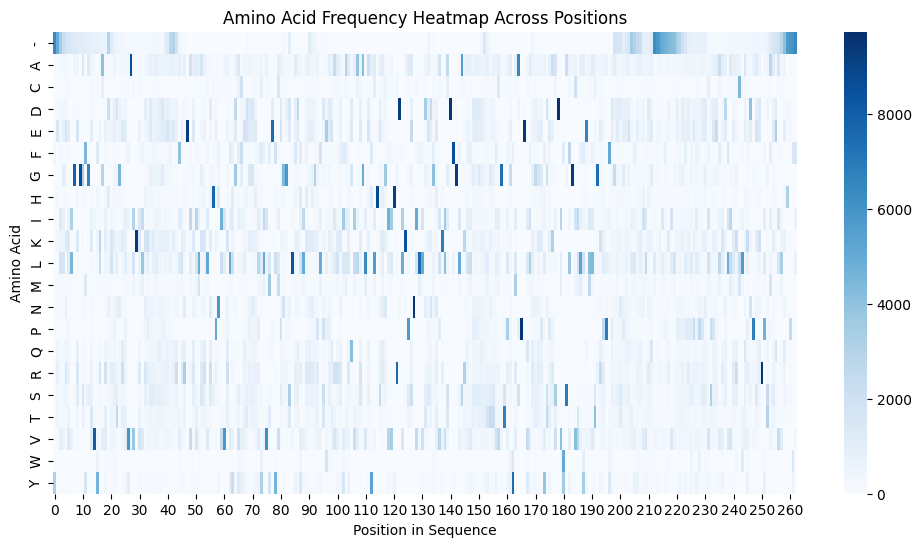

In [ ]:
def plot_heatmap(encoded_matrix) :
    """
    Plots a heatmap showing amino acid occurrences across sequence positions.

    Parameter:
        encoded_matrix (np.ndarray): One-hot encoded dataset of shape (M, L, 21).
    """
    if encoded_matrix.size == 0:
        print("No valid sequences to visualize.")
        return

    # Aggregate across all sequences to get frequency per position
    positional_counts = encoded_matrix.sum(axis=0)  # Shape: (L, 21)

    # Define amino acids (gap first)
    amino_acids = '-ACDEFGHIKLMNPQRSTVWY'

    # Create heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(positional_counts.T, cmap="Blues", xticklabels=10, yticklabels=amino_acids)
    plt.xlabel("Position in Sequence")
    plt.ylabel("Amino Acid")
    plt.title("Amino Acid Frequency Heatmap Across Positions")
    plt.show()

# Call function
plot_heatmap(encoded_matrix)


#PCA dimensionality reduction

## Choosing the number of components

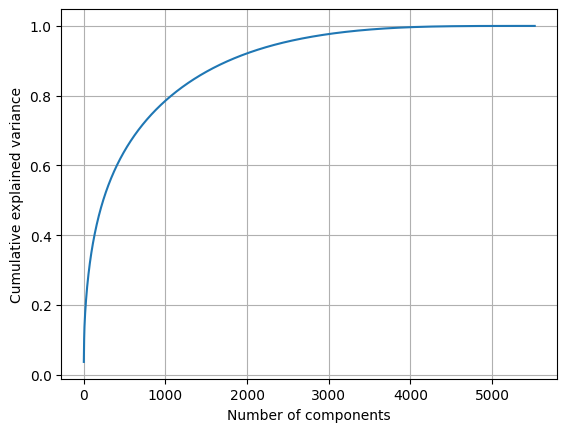

In [ ]:
pca = PCA().fit(flattened_matrix)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()

As we can observe, the curve shows that with 2000 components, we can have 95% of the variance


In [ ]:
pca = PCA(n_components=10)
reduced_matrix = pca.fit_transform(flattened_matrix)
print(reduced_matrix, "\n")

# Check explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_, "\n")
print("Cumulative explained variance:", sum(pca.explained_variance_ratio_))

[[ 2.2561812  -1.4504641   0.14812092 ...  1.6989292   0.6796671
   0.22329633]
 [-2.4786475  -3.9538176  -4.883555   ...  2.2395568   1.4908202
   0.24742751]
 [-2.0932424  -3.7022285  -4.851676   ...  2.4550633   1.578101
  -0.34618348]
 ...
 [-1.3838532  -1.8764739  -5.7745757  ...  1.546429    2.5922952
  -1.9305019 ]
 [-3.1392882  -2.2586575   1.1771003  ...  1.913577    0.7442614
  -2.5743814 ]
 [-2.0348701  -4.044807   -4.7848177  ... -1.1166626  -0.6678399
   2.5011442 ]] 

Explained variance ratio: [0.03614971 0.02504248 0.01637646 0.01449682 0.01094356 0.00982475
 0.00852293 0.00628768 0.00614059 0.00585355] 

Cumulative explained variance: 0.13963853


In [ ]:
print(f"len flattend:{flattened_matrix.shape} len reduced {reduced_matrix.shape}")

len flattend:(9960, 5523) len reduced (9960, 10)


## Compare PCA components

### PC1 vs PC2

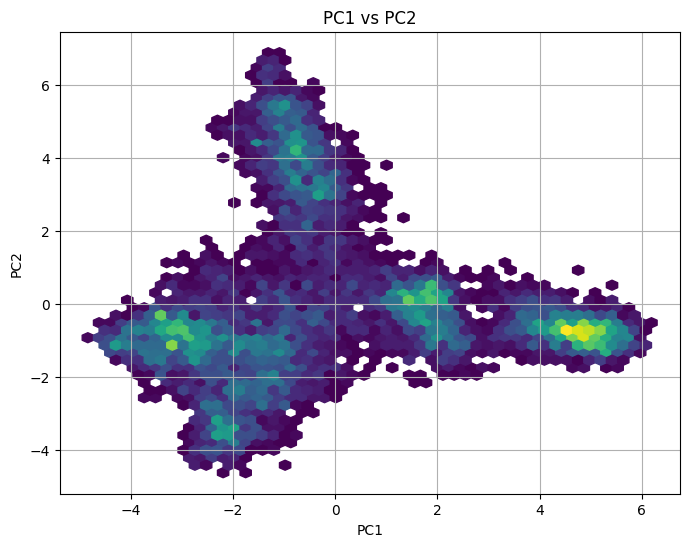

In [ ]:
plt.figure(figsize=(8, 6))
plt.hexbin(reduced_matrix[:, 0], reduced_matrix[:, 1], gridsize=50, cmap='viridis', mincnt=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2")
plt.grid()
plt.show()

### PC2 vs PC3

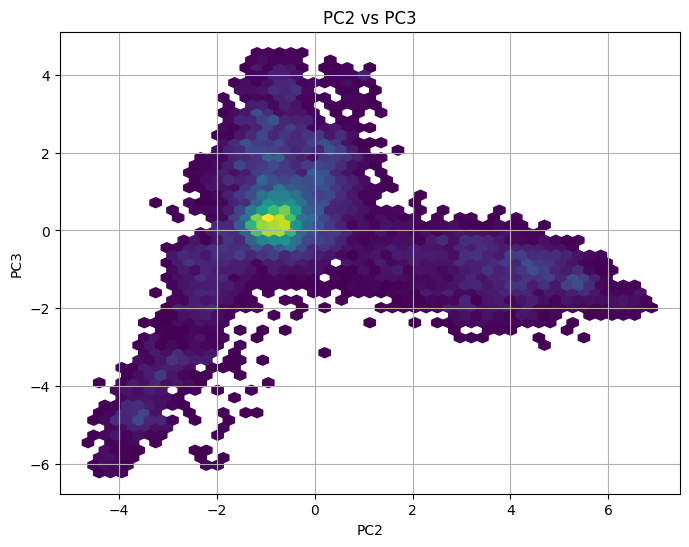

In [ ]:
plt.figure(figsize=(8, 6))
plt.hexbin(reduced_matrix[:, 1], reduced_matrix[:, 2], gridsize=50, cmap='viridis', mincnt=1)
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PC2 vs PC3")
plt.grid()
plt.show()

### Comparison Matrix of PC1 to PC5

<ipython-input-15-1daca5e03cdc>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


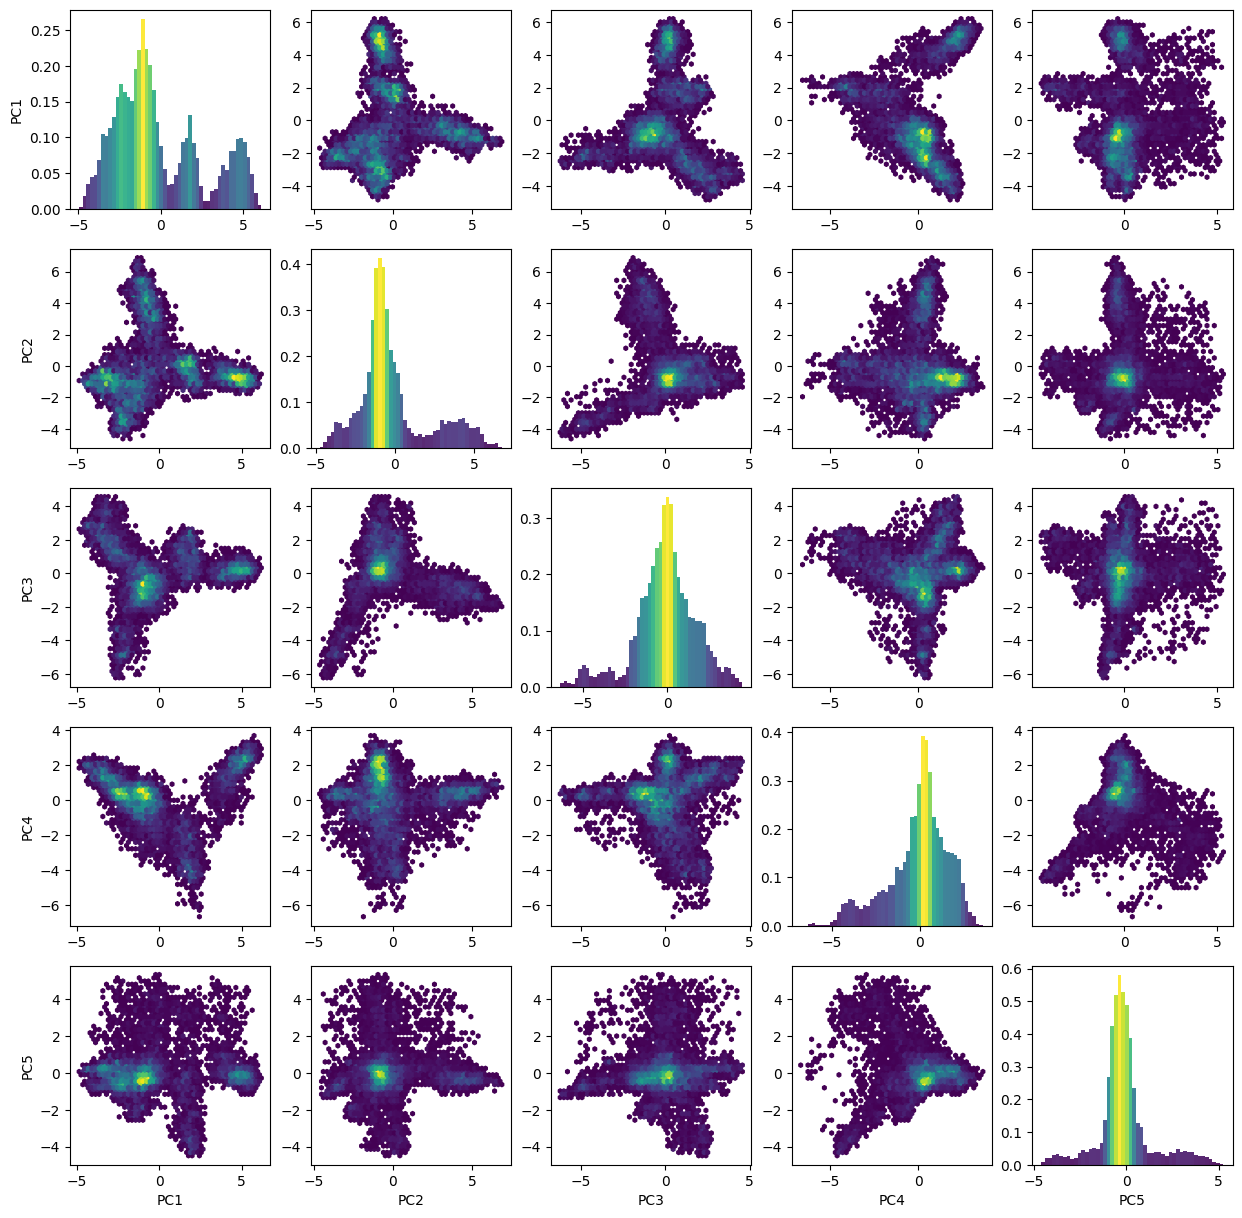

In [ ]:
def plot_pc_comparison(reduced_matrix, n_pc) :
    """
    Plots a n_pc x n_pc matrix comparing the first n_pc PCA components.
    Each subplot compares two components.

    Parameters:
        reduced_matrix (np.ndarray): Matrix of reduced dimensions from PCA, shape (M, n_components).
        n_pc (int): Number of principal components to compare to each other
    """
    # Set the labels for the x and y axes
    component_labels = [f"PC{i+1}" for i in range(n_pc)]

    # Create a 5x5 grid of subplots
    fig, axes = plt.subplots(nrows=n_pc, ncols=n_pc, figsize=(15, 15))

    # Loop through each subplot and plot the comparison of PCA components
    for i in range(n_pc) :
        for j in range(n_pc) :
            ax = axes[j, i]

            if i != j:
                ax.hexbin(reduced_matrix[:, i], reduced_matrix[:, j], gridsize=50, cmap='viridis', mincnt=1)
            else:
                counts, bins = np.histogram(reduced_matrix[:, i], bins=50, density=True)
                norm = mcolors.Normalize(vmin=min(counts), vmax=max(counts))
                cmap = cm.get_cmap('viridis')

                # Plot histogram with colored bars
                for k in range(len(bins) - 1):
                    ax.bar(bins[k], counts[k], width=bins[k+1] - bins[k], color=cmap(norm(counts[k])), alpha=0.9)

    # X-axis and Y-axis labels
    for i in range(n_pc) :
        axes[n_pc-1, i].set_xlabel(component_labels[i])
        axes[i, 0].set_ylabel(component_labels[i])

    # plt.suptitle('Projection for the first 5 components')
    plt.show()

plot_pc_comparison(reduced_matrix, 5)

### PCA correlation heatmap

# t-SNE

In [ ]:
# Reduce high-dimensional PCA data to 2D with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
reduced_tsne = tsne.fit_transform(flattened_matrix)

# Plot the 2D t-SNE representation
plt.figure(figsize=(8, 6))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection of Data (2D)')
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


# K-means clustering
To find the optimal number of clusters for K-means, we will use the Elbow method. The "elbow" (bend in the curve) suggests the optimal k.  
After finding an optimal range of value for k, we will try to compare them using Silhouette Score to find the highest score among eachother. The Silhouette Score is a metric used to evaluate the quality of clusters created by clustering algorithms such as K-means. It measures how well samples are clustered with other samples that are similar to each other. The silhouette score ranges from -1 to 1, where a score close to 1 indicates that the samples are well-clustered, a score close to 0 indicates overlapping clusters, and a negative score indicates that the samples might have been assigned to the wrong cluster.

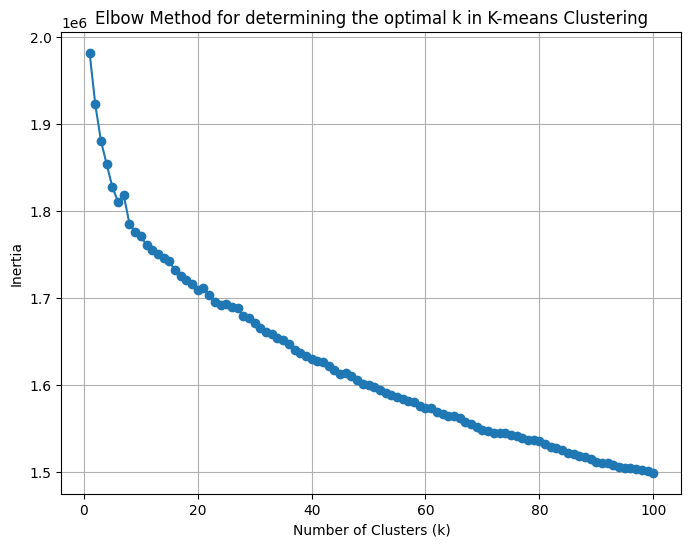

In [ ]:
inertias = []
ks = range(1, 101)  # Try k from 1 to 100 as there exists many type of kinases
sequences_matrix = flattened_matrix

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sequences_matrix)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(ks, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for determining the optimal k in K-means Clustering")
plt.grid(True)
plt.show()

As we can see, the elbow seems to be around k = 10.

k=2 --> Silhouette Score: 0.0295
k=3 --> Silhouette Score: 0.0306
k=4 --> Silhouette Score: 0.0366
k=5 --> Silhouette Score: 0.0320
k=6 --> Silhouette Score: 0.0310
k=7 --> Silhouette Score: 0.0366
k=8 --> Silhouette Score: 0.0266
k=9 --> Silhouette Score: 0.0298
k=10 --> Silhouette Score: 0.0307
k=11 --> Silhouette Score: 0.0310
k=12 --> Silhouette Score: 0.0314
k=13 --> Silhouette Score: 0.0272
k=14 --> Silhouette Score: 0.0218
k=15 --> Silhouette Score: 0.0257
k=16 --> Silhouette Score: 0.0258
k=17 --> Silhouette Score: 0.0244
k=18 --> Silhouette Score: 0.0201
k=19 --> Silhouette Score: 0.0217
k=20 --> Silhouette Score: 0.0216
k=21 --> Silhouette Score: 0.0266
k=22 --> Silhouette Score: 0.0269
k=23 --> Silhouette Score: 0.0282
k=24 --> Silhouette Score: 0.0289
k=25 --> Silhouette Score: 0.0294
k=26 --> Silhouette Score: 0.0291
k=27 --> Silhouette Score: 0.0295
k=28 --> Silhouette Score: 0.0305
k=29 --> Silhouette Score: 0.0300
k=30 --> Silhouette Score: 0.0315
k=31 --> Silhouette Sc

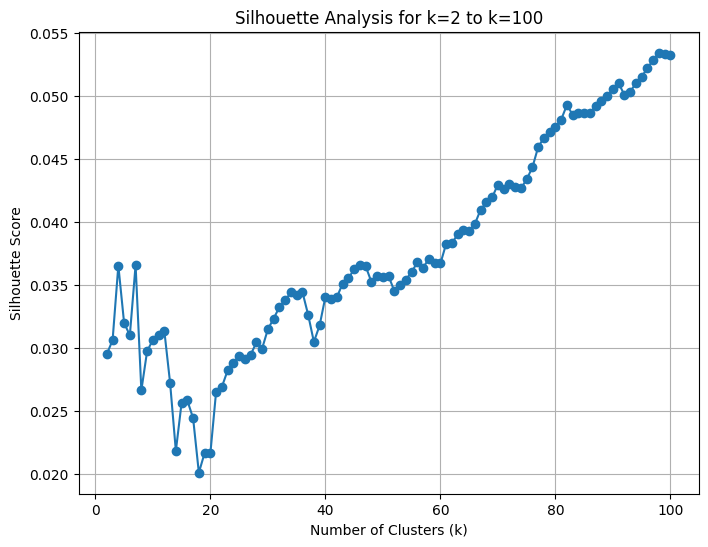

In [ ]:
k_values = range(2, 101)
silhouette_scores = []
sequences_matrix = flattened_matrix

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(sequences_matrix)
    score = silhouette_score(sequences_matrix, labels)
    silhouette_scores.append(score)
    print(f"k={k} --> Silhouette Score: {score:.4f}")

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title(f"Silhouette Analysis for k={min(k_values)} to k={max(k_values)}")
plt.grid(True)
plt.show()


It seems that k = 10 has the highest silhouette score, suggesting that 6 clusters may provide the best separation among these options. However, since all the scores are close to 0, this indicates that the clusters are overlapping.  
Let's test the clustering algorithm with k ranging from 1 to 29 and observe the results on the PC projections.

In [ ]:
# Create a folder to save the plots
output_dir = "Plots for k-means"
os.makedirs(output_dir, exist_ok=True)

k_values =  range(1, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_kmeans = kmeans.fit_predict(flattened_matrix)
    centroids = kmeans.cluster_centers_

    pca = PCA(n_components=10)
    reduced_matrix = pca.fit_transform(flattened_matrix)
    centroids_pca = pca.transform(centroids)

    # Set the labels for the x and y axes
    component_labels = [f"PC{i+1}" for i in range(5)]

    # Create a 5x5 grid of subplots
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

    # Loop through each subplot and plot the comparison of PCA components with clusters
    for i in range(5) :
        for j in range(5) :
            ax = axes[j, i]
            pc_i_pc_j = reduced_matrix[:, [i, j]]

            if i != j:
                # Plot each cluster with a unique color and draw its convex hull
                colors = plt.cm.viridis(np.linspace(0, 1, k))
                for cluster in range(k):
                    # Get points in the current cluster
                    cluster_points = pc_i_pc_j[labels_kmeans == cluster]

                    # Plot the points
                    ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                                s=10, color=colors[cluster], alpha=0.7,
                                label=f"Cluster {cluster + 1}")

                    # Draw convex hull if there are enough points
                    if cluster_points.shape[0] >= 3:
                        hull = ConvexHull(cluster_points)
                        # Get the convex hull vertices and create a closed polygon
                        hull_points = cluster_points[hull.vertices]
                        hull_points = np.concatenate((hull_points, hull_points[:1]), axis=0)
                        ax.plot(hull_points[:, 0], hull_points[:, 1],
                                color=colors[cluster], lw=1, linestyle='--')

                # Plot centroids
                ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=100,
                            color='red', label='Centroids')

                # Customize plot
                ax.grid(True)
            else:
                counts, bins = np.histogram(reduced_matrix[:, i], bins=50, density=True)
                norm = mcolors.Normalize(vmin=min(counts), vmax=max(counts))
                cmap = plt.get_cmap('viridis')

                # Plot histogram with colored bars
                for bin in range(len(bins) - 1):
                    ax.bar(bins[bin], counts[bin], width=bins[bin+1] - bins[bin], color=cmap(norm(counts[bin])), alpha=0.9)

    # X-axis and Y-axis labels
    for i in range(5) :
        axes[4, i].set_xlabel(component_labels[i])
        axes[i, 0].set_ylabel(component_labels[i])

    # Save the plot
    plt.suptitle('Projection for the first 5 components')
    filename = os.path.join(output_dir, f'plot_for_k={k}.png')
    plt.savefig(filename)
    plt.close()

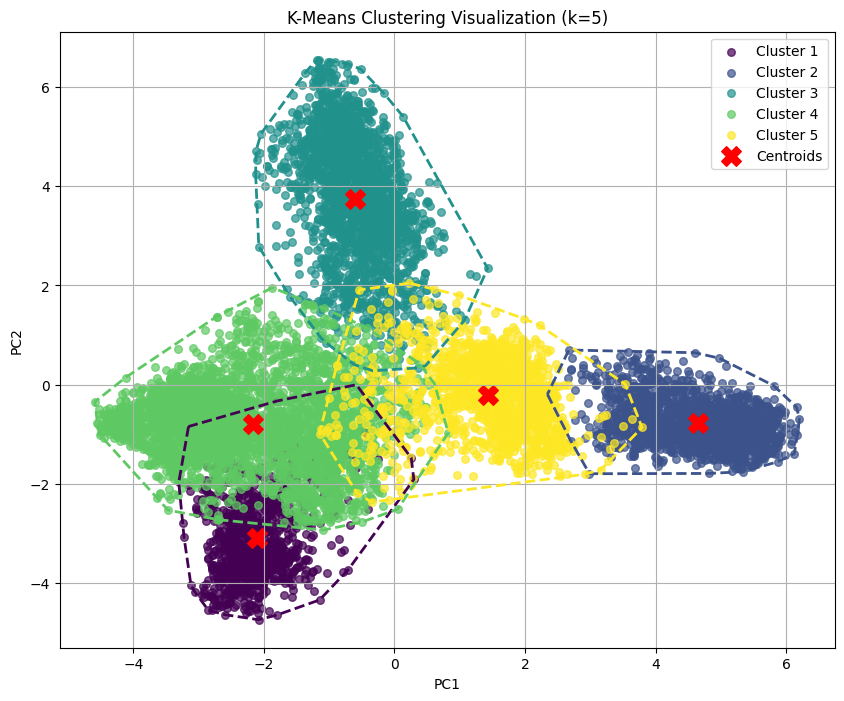

In [ ]:
k = 5
# Fit K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(flattened_matrix)
centroids = kmeans.cluster_centers_

# Create a figure for the visualization
plt.figure(figsize=(10, 8))
pc1_pc2 = reduced_matrix[:, :2]
centroids_pca = pca.transform(centroids)
# Plot each cluster with a unique color and draw its convex hull
colors = plt.cm.viridis(np.linspace(0, 1, k))
for cluster in range(k):
    # Get points in the current cluster
    cluster_points = pc1_pc2[labels_kmeans == cluster]

    # Plot the points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=30, color=colors[cluster], alpha=0.7,
                label=f"Cluster {cluster + 1}")

    # Draw convex hull if there are enough points
    if cluster_points.shape[0] >= 3:
        hull = ConvexHull(cluster_points)
        # Get the convex hull vertices and create a closed polygon
        hull_points = cluster_points[hull.vertices]
        hull_points = np.concatenate((hull_points, hull_points[:1]), axis=0)
        plt.plot(hull_points[:, 0], hull_points[:, 1],
                 color=colors[cluster], lw=2, linestyle='--')

# Plot centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200,
            color='red', label='Centroids')

# Customize plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clustering Visualization (k={k})")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def interactive_3d_clustering(flattened_matrix, k=10):
    # Reduce to 3D PCA
    pca = PCA(n_components=3)
    reduced_3d = pca.fit_transform(flattened_matrix)

    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(flattened_matrix)

    # Create DataFrame with components and labels
    df = pd.DataFrame(reduced_3d, columns=['PC1', 'PC2', 'PC3'])
    df['Cluster'] = [f'Cluster {l+1}' for l in labels]
    df['Size'] = 40  # Base size for all points

    # Add centroids in PCA space
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids_pca,
                              columns=['PC1', 'PC2', 'PC3'])
    centroid_df['Cluster'] = [f'Centroid {i+1}' for i in range(k)]
    centroid_df['Size'] = 300  # Larger size for centroids

    # Combine points and centroids
    combined_df = pd.concat([df, centroid_df])

    # Create interactive 3D plot
    fig = px.scatter_3d(
        combined_df,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Cluster',
        size='Size',
        size_max=25,
        opacity=0.8,
        hover_data={
            'PC1': ':.3f',
            'PC2': ':.3f',
            'PC3': ':.3f',
            'Cluster': True,
            'Size': False
        },
        title=f'3D Interactive Clustering (k={k})',
        color_discrete_sequence=px.colors.qualitative.Plotly,
        category_orders={"Cluster": [f'Cluster {i+1}' for i in range(k)] +
                         [f'Centroid {i+1}' for i in range(k)]}
    )

    # Add variance explained to axis labels
    explained_var = pca.explained_variance_ratio_ * 100
    fig.update_layout(
         width=1400,  # Wider figure
        height=900,   # Taller figure
        scene=dict(
            xaxis_title=f'PC1 ({explained_var[0]:.1f}% Variance)',
            yaxis_title=f'PC2 ({explained_var[1]:.1f}% Variance)',
            zaxis_title=f'PC3 ({explained_var[2]:.1f}% Variance)',
            camera=dict(
                eye=dict(x=2.0, y=2.0, z=0.1)  # Initial view angle
            )
        ),
        legend=dict(
            title='Clusters',
            itemsizing='constant'
        )
    )

    # Customize marker appearance
    fig.update_traces(
        marker=dict(
            line=dict(width=0.5, color='DarkSlateGrey'),
            symbol='circle'
        ),
        selector=dict(mode='markers')
    )

    return fig

fig = interactive_3d_clustering(flattened_matrix, k=10)
fig.show()

# Gaussian Mixture Model
We will use Gaussian Mixture Model as well for clustering and compare it to K-means to see which clustering method is more optimal for our purposes.

How many Gaussians ?  
We will find out using Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) methods.

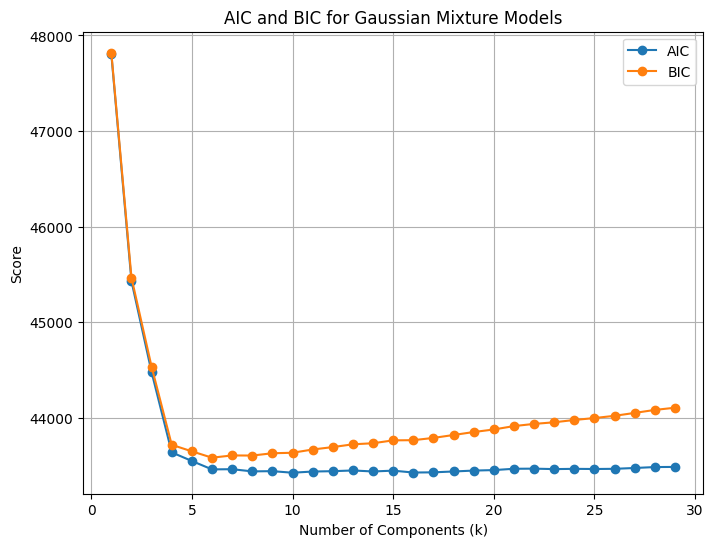

In [ ]:
pca = PCA(n_components=1)
reduced_matrix = pca.fit_transform(flattened_matrix)

aic_scores = []
bic_scores = []
k_values = np.arange(1, 30)  # Trying from 1 to 29 components

for k in k_values:
    clf = GaussianMixture(k, max_iter=1000, random_state=30).fit(reduced_matrix)
    bic_scores.append(clf.bic(reduced_matrix))
    aic_scores.append(clf.aic(reduced_matrix))

plt.figure(figsize=(8, 6))
plt.plot(k_values, aic_scores, marker='o', label='AIC')
plt.plot(k_values, bic_scores, marker='o', label='BIC')
plt.xlabel("Number of Components (k)")
plt.ylabel("Score")
plt.title("AIC and BIC for Gaussian Mixture Models")
plt.legend()
plt.grid(True)
plt.show()

As we can see, the elbow seems to be around k = 5.

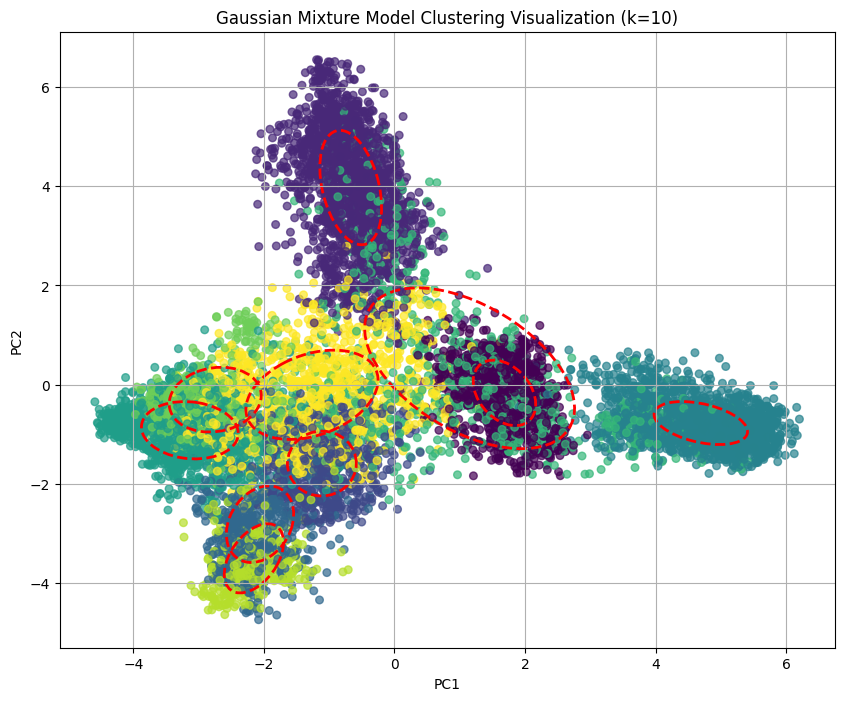

In [ ]:
# Function to plot ellipses for each Gaussian component
def plot_gmm_ellipses(gmm, ax):
    for n, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        if gmm.covariance_type == 'full':
            covar = covar[:2, :2]
        # Compute eigenvalues and eigenvectors to determine the ellipse parameters
        v, w = np.linalg.eigh(covar)
        # Sort the eigenvalues and eigenvectors
        order = v.argsort()[::-1]
        v = v[order]
        w = w[:, order]
        # Compute the angle of the ellipse in degrees
        angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))
        # Use a factor (e.g., 2 standard deviations) to set the ellipse size
        factor = 2
        width, height = factor * np.sqrt(v)
        ellip = Ellipse(xy=mean, width=width, height=height, angle=angle,
                        edgecolor='red', facecolor='none', lw=2, linestyle='--')
        ax.add_artist(ellip)

# Create the visualization
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Scatter plot of the data points colored by GMM labels
pca = PCA(n_components=10)
reduced_matrix = pca.fit_transform(flattened_matrix)
k = 10
gmm = GaussianMixture(n_components=k, covariance_type='full').fit(reduced_matrix)
labels_gmm = gmm.predict(reduced_matrix)

scatter = ax.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels_gmm, cmap='viridis', s=30, alpha=0.7)

# Overlay the Gaussian ellipses
plot_gmm_ellipses(gmm, ax)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Gaussian Mixture Model Clustering Visualization (k={k})")
plt.grid(True)
plt.show()


When we compare the PC projection after k-means clustering with the one after GMM clustering, we observe that the clusters are approximately the same - something that does not hold for all values of k. This suggests that 5 is a good number of clusters.

# Comparing K-means and Gaussian clustering method using Silhouette Scores

In [ ]:
# K-Means clustering (k=5)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(flattened_matrix)
silhouette_kmeans = silhouette_score(flattened_matrix, labels_kmeans)
print("K-Means Silhouette Score:", silhouette_kmeans)

# GMM clustering (k=5)
k = 5
pca = PCA(n_components=10)
reduced_matrix = pca.fit_transform(flattened_matrix)
gmm = GaussianMixture(n_components=k, random_state=42).fit(reduced_matrix)
labels_gmm = gmm.predict(reduced_matrix)
silhouette_gmm = silhouette_score(reduced_matrix, labels_gmm)
print("GMM Silhouette Score:", silhouette_gmm)

K-Means Silhouette Score: 0.029119084
GMM Silhouette Score: 0.33164966


K-Means Silhouette Score is 0.029119084 and GMM Silhouette Score is 0.33164966.



# Extracting labeled datasets from reviewed sequences
In this section, we will extract the codes of each sequence from the FASTA file, query UniProt for their information via URL requests, and finally retrieve datasets containing sequences with the same label.

## Data retrieval

In [ ]:
def retrieve_seq_code_from_fasta(input_f):
    codes = []
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                parts = line.split('|')
                if len(parts) > 2:
                    codes.append(parts[1])
    return codes

sequence_list, sequence_codes = retrieve_seq_and_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta')

In [ ]:
def get_protein_info(uniprot_id):
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            return data
        else:
            return f"Error {response.status_code}: Cannot retrieve data."

In [ ]:
def retrieve_protein_names(codes):
    protein_names = []
    for code in codes:
        info = get_protein_info(code)
        protein_description = info['proteinDescription']
        protein_name = protein_description['recommendedName']['fullName']['value']
        protein_names.append(protein_name)
    return protein_names

protein_names = retrieve_protein_names(sequence_codes)

In [ ]:
def retrieve_labels(codes, protein_names):
    labels = {}

    for code, name in zip(codes, protein_names):
        m = re.search(r"([\w\s/-]+) kinase", name, re.IGNORECASE)
        if m:
            if m.group(1) in labels.keys():
                labels[m.group(1)].append(code)
            else :
                labels[m.group(1)] = [code]

    return labels


labels = retrieve_labels(sequence_codes, protein_names)
print(f"Number of unique labels : {len(labels)}\n")

total_proteins = 0
for label, codes in sorted(labels.items(), key=lambda x: len(x[1]), reverse=True):
    count = len(codes)
    total_proteins += count
    print(f"{label}: {count}")

print(f"\nTotal number of classified proteins : {total_proteins}")

Number of unique labels : 235

Serine/threonine-protein: 933
Mitogen-activated protein: 203
Cyclin-dependent: 192
Probable serine/threonine-protein: 163
Casein: 104
Protein: 96
Calcium-dependent protein: 85
Calcium/calmodulin-dependent protein: 48
Mitogen-activated protein kinase kinase: 45
Dual specificity mitogen-activated protein kinase: 37
Ribosomal protein S6: 34
Aurora: 32
CBL-interacting protein: 31
cAMP-dependent protein: 31
CBL-interacting serine/threonine-protein: 26
Putative serine/threonine-protein: 23
L-type lectin-domain containing receptor: 22
Dual specificity tyrosine-phosphorylation-regulated: 21
Dual specificity protein: 21
Eukaryotic translation initiation factor 2-alpha: 20
Wee1-like protein: 19
Myosin light chain: 19
LRR receptor-like serine/threonine-protein: 19
G protein-coupled receptor: 19
cGMP-dependent protein: 18
Glycogen synthase: 18
G-type lectin S-receptor-like serine/threonine-protein: 17
Dual serine/threonine and tyrosine protein: 16
Mitogen-activated p

In [ ]:
def retrieve_fasta_from_codes(input_f, output_f, code_list):

    def extract_code(fasta_id):
      return fasta_id.split("|")[1] if "|" in fasta_id else fasta_id

    filtered_sequences = [record for record in SeqIO.parse(input_f, "fasta") if extract_code(record.id) in code_list]

    SeqIO.write(filtered_sequences, output_f, "fasta")

os.makedirs("/content/Labeled_unaligned_fastas", exist_ok=True)

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/serine_threonine_kinases.fasta', labels['Serine/threonine-protein'])
retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/serine_threonine_kinases_2.fasta', labels['Probable serine/threonine-protein'])
retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/serine_threonine_kinases_3.fasta', labels['CBL-interacting serine/threonine-protein'])
retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/serine_threonine_kinases_4.fasta', labels['Putative serine/threonine-protein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/mitogen_activated_kinases.fasta', labels['Mitogen-activated protein'])
retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/mitogen_activated_kinases_2.fasta', labels['Mitogen-activated protein kinase kinase'])
retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/mitogen_activated_kinases_3.fasta', labels['Dual specificity mitogen-activated protein kinase'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/cyclin_dependent_kinases.fasta', labels['Cyclin-dependent'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/casein_kinases.fasta', labels['Casein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/protein_kinases.fasta', labels['Protein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/calcium_dependent_kinases.fasta', labels['Calcium-dependent protein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/calcium_calmodulin_dependent_kinases.fasta', labels['Calcium/calmodulin-dependent protein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/ribosomal_protein_S6_kinases.fasta', labels['Ribosomal protein S6'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/aurora_kinases.fasta', labels['Aurora'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/CBL_interacting_protein_kinases.fasta', labels['CBL-interacting protein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/cAMP_dependent_protein_kinases.fasta', labels['cAMP-dependent protein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/L_type_lectin_kinases.fasta', labels['L-type lectin-domain containing receptor'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/tyrosine_kinases.fasta', labels['Dual specificity tyrosine-phosphorylation-regulated'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/dual_specificity_protein_kinases.fasta', labels['Dual specificity protein'])

retrieve_fasta_from_codes('/content/uniprotkb_PF00069_AND_reviewed_true_2025_03_18.fasta', '/content/Labeled_unaligned_fastas/eukaryotic_translation_initiation_factor_kinases.fasta', labels['Eukaryotic translation initiation factor 2-alpha'])

In [ ]:
ser_thr_seq_list, ser_thr_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/serine_threonine_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of serine-threonine kinase sequences : {len(ser_thr_seq_list)}")
print(f"Length of a serine-threonine kinase sequence : {len(ser_thr_seq_list[0])}\n")

mitogen_seq_list, mitogen_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/mitogen_activated_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of mitogen-activated kinase sequences : {len(mitogen_seq_list)}")
print(f"Length of a mitogen-activated kinase sequence : {len(mitogen_seq_list[0])}\n")

cyclin_seq_list, cyclin_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/cyclin_dependent_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of cyclin-dependent kinase sequences : {len(cyclin_seq_list)}")
print(f"Length of a cyclin-dependent kinase sequence : {len(cyclin_seq_list[0])}\n")

casein_seq_list, casein_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/casein_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of casein kinase sequences : {len(casein_seq_list)}")
print(f"Length of a casein kinase sequence : {len(casein_seq_list[0])}\n")

protein_seq_list, protein_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/protein_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of protein kinase sequences : {len(protein_seq_list)}")
print(f"Length of a protein kinase sequence : {len(protein_seq_list[0])}\n")

calcium_seq_list, calcium_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/calcium_dependent_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of calcium dependent kinase sequences : {len(calcium_seq_list)}")
print(f"Length of a calcium dependent kinase sequence : {len(calcium_seq_list[0])}\n")

calcium_calmodulin_seq_list, calcium_calmodulin_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/calcium_calmodulin_dependent_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of calcium/calmodulin dependent kinase sequences : {len(calcium_calmodulin_seq_list)}")
print(f"Length of a calcium/calmodulin dependent kinase sequence : {len(calcium_calmodulin_seq_list[0])}\n")

ribosomal_seq_list, ribosomal_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/ribosomal_protein_S6_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of ribosomal protein S6 kinase sequences : {len(ribosomal_seq_list)}")
print(f"Length of a ribosomal protein S6 kinase sequence : {len(ribosomal_seq_list[0])}\n")

aurora_seq_list, aurora_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/aurora_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of aurora kinase sequences : {len(aurora_seq_list)}")
print(f"Length of a aurora kinase sequence : {len(aurora_seq_list[0])}\n")

CBL_seq_list, CBL_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/CBL_interacting_protein_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of CBL interacting protein kinase sequences : {len(CBL_seq_list)}")
print(f"Length of a CBL interacting protein kinase sequence : {len(CBL_seq_list[0])}\n")

cAMP_dependent_seq_list, cAMP_dependent_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/cAMP_dependent_protein_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of cAMP dependent kinase sequences : {len(cAMP_dependent_seq_list)}")
print(f"Length of a cAMP dependent kinase sequence : {len(cAMP_dependent_seq_list[0])}\n")

L_type_lectin_seq_list, L_type_lectin_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/L_type_lectin_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of L-type lectin kinase sequences : {len(L_type_lectin_seq_list)}")
print(f"Length of a L-type lectin kinase sequence : {len(L_type_lectin_seq_list[0])}\n")

tyrosine_seq_list, tyrosine_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/tyrosine_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of tyrosine kinase sequences : {len(tyrosine_seq_list)}")
print(f"Length of a tyrosine kinase sequence : {len(tyrosine_seq_list[0])}\n")

dual_specificity_seq_list, dual_specificity_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/dual_specificity_protein_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of dual specificity kinase sequences : {len(dual_specificity_seq_list)}")
print(f"Length of a dual specificity kinase sequence : {len(dual_specificity_seq_list[0])}\n")

eukaryotic_seq_list, eukaryotic_codes = retrieve_seq_and_codes('/content/Labeled_noInserts_noGaps_noDuplicates_fastas/eukaryotic_translation_initiation_factor_kinases_noInserts_noGaps_noDuplicates.fasta')
print(f"Number of eukaryotic translation initiation factor kinase sequences : {len(eukaryotic_seq_list)}")
print(f"Length of a eukaryotic translation initiation factor kinase sequence : {len(eukaryotic_seq_list[0])}\n")

Number of serine-threonine kinase sequences : 944
Length of a serine-threonine kinase sequence : 263

Number of mitogen-activated kinase sequences : 255
Length of a mitogen-activated kinase sequence : 263

Number of cyclin-dependent kinase sequences : 172
Length of a cyclin-dependent kinase sequence : 263

Number of casein kinase sequences : 31
Length of a casein kinase sequence : 263

Number of protein kinase sequences : 78
Length of a protein kinase sequence : 263

Number of calcium dependent kinase sequences : 80
Length of a calcium dependent kinase sequence : 263

Number of calcium/calmodulin dependent kinase sequences : 32
Length of a calcium/calmodulin dependent kinase sequence : 263

Number of ribosomal protein S6 kinase sequences : 23
Length of a ribosomal protein S6 kinase sequence : 263

Number of aurora kinase sequences : 32
Length of a aurora kinase sequence : 263

Number of CBL interacting protein kinase sequences : 31
Length of a CBL interacting protein kinase sequence : 

In [ ]:
ser_thr_encoded_matrix = encode_sequences_one_hot_with_gap(ser_thr_seq_list, max_length=None)
print("Shape of encoded matrix :", ser_thr_encoded_matrix.shape, "\n")

mitogen_encoded_matrix, removed_indices = encode_sequences_one_hot_with_gap(mitogen_seq_list, max_length=None, return_removed_indices=True)
print("Shape of encoded matrix :", mitogen_encoded_matrix.shape, "\n")
mitogen_codes = [code for idx, code in enumerate(mitogen_codes) if idx not in removed_indices]

cyclin_encoded_matrix = encode_sequences_one_hot_with_gap(cyclin_seq_list, max_length=None)
print("Shape of encoded matrix :", cyclin_encoded_matrix.shape, "\n")

casein_encoded_matrix = encode_sequences_one_hot_with_gap(casein_seq_list, max_length=None)
print("Shape of encoded matrix :", casein_encoded_matrix.shape, "\n")

protein_encoded_matrix = encode_sequences_one_hot_with_gap(protein_seq_list, max_length=None)
print("Shape of encoded matrix :", protein_encoded_matrix.shape, "\n")

calcium_encoded_matrix = encode_sequences_one_hot_with_gap(calcium_seq_list, max_length=None)
print("Shape of encoded matrix :", calcium_encoded_matrix.shape, "\n")

calcium_calmodulin_encoded_matrix = encode_sequences_one_hot_with_gap(calcium_calmodulin_seq_list, max_length=None)
print("Shape of encoded matrix :", calcium_calmodulin_encoded_matrix.shape, "\n")

ribosomal_encoded_matrix = encode_sequences_one_hot_with_gap(ribosomal_seq_list, max_length=None)
print("Shape of encoded matrix :", ribosomal_encoded_matrix.shape, "\n")

aurora_encoded_matrix = encode_sequences_one_hot_with_gap(aurora_seq_list, max_length=None)
print("Shape of encoded matrix :", aurora_encoded_matrix.shape, "\n")

CBL_encoded_matrix = encode_sequences_one_hot_with_gap(CBL_seq_list, max_length=None)
print("Shape of encoded matrix :", CBL_encoded_matrix.shape, "\n")

cAMP_dependent_encoded_matrix = encode_sequences_one_hot_with_gap(cAMP_dependent_seq_list, max_length=None)
print("Shape of encoded matrix :", cAMP_dependent_encoded_matrix.shape, "\n")

L_type_lectin_encoded_matrix = encode_sequences_one_hot_with_gap(L_type_lectin_seq_list, max_length=None)
print("Shape of encoded matrix :", L_type_lectin_encoded_matrix.shape, "\n")

tyrosine_encoded_matrix = encode_sequences_one_hot_with_gap(tyrosine_seq_list, max_length=None)
print("Shape of encoded matrix :", tyrosine_encoded_matrix.shape, "\n")

dual_specificity_encoded_matrix = encode_sequences_one_hot_with_gap(dual_specificity_seq_list, max_length=None)
print("Shape of encoded matrix :", dual_specificity_encoded_matrix.shape, "\n")

eukaryotic_encoded_matrix = encode_sequences_one_hot_with_gap(eukaryotic_seq_list, max_length=None)
print("Shape of encoded matrix :", eukaryotic_encoded_matrix.shape, "\n")

Shape of encoded matrix : (944, 263, 21) 

Shape of encoded matrix : (254, 263, 21) 

Shape of encoded matrix : (172, 263, 21) 

Shape of encoded matrix : (31, 263, 21) 

Shape of encoded matrix : (78, 263, 21) 

Shape of encoded matrix : (80, 263, 21) 

Shape of encoded matrix : (32, 263, 21) 

Shape of encoded matrix : (23, 263, 21) 

Shape of encoded matrix : (32, 263, 21) 

Shape of encoded matrix : (31, 263, 21) 

Shape of encoded matrix : (27, 263, 21) 

Shape of encoded matrix : (12, 263, 21) 

Shape of encoded matrix : (16, 263, 21) 

Shape of encoded matrix : (17, 263, 21) 

Shape of encoded matrix : (8, 263, 21) 



In [ ]:
M, L, A = ser_thr_encoded_matrix.shape
ser_thr_flattened_matrix = ser_thr_encoded_matrix.reshape(M, L*A)
print(ser_thr_flattened_matrix.shape, "\n")

M, L, A = mitogen_encoded_matrix.shape
mitogen_flattened_matrix = mitogen_encoded_matrix.reshape(M, L*A)
print(mitogen_flattened_matrix.shape, "\n")

M, L, A = cyclin_encoded_matrix.shape
cyclin_flattened_matrix = cyclin_encoded_matrix.reshape(M, L*A)
print(cyclin_flattened_matrix.shape, "\n")

M, L, A = casein_encoded_matrix.shape
casein_flattened_matrix = casein_encoded_matrix.reshape(M, L*A)
print(casein_flattened_matrix.shape, "\n")

M, L, A = protein_encoded_matrix.shape
protein_flattened_matrix = protein_encoded_matrix.reshape(M, L*A)
print(protein_flattened_matrix.shape, "\n")

M, L, A = calcium_encoded_matrix.shape
calcium_flattened_matrix = calcium_encoded_matrix.reshape(M, L*A)
print(calcium_flattened_matrix.shape, "\n")

M, L, A = calcium_calmodulin_encoded_matrix.shape
calcium_calmodulin_flattened_matrix = calcium_calmodulin_encoded_matrix.reshape(M, L*A)
print(calcium_calmodulin_flattened_matrix.shape, "\n")

M, L, A = ribosomal_encoded_matrix.shape
ribosomal_flattened_matrix = ribosomal_encoded_matrix.reshape(M, L*A)
print(ribosomal_flattened_matrix.shape, "\n")

M, L, A = aurora_encoded_matrix.shape
aurora_flattened_matrix = aurora_encoded_matrix.reshape(M, L*A)
print(aurora_flattened_matrix.shape, "\n")

M, L, A = CBL_encoded_matrix.shape
CBL_flattened_matrix = CBL_encoded_matrix.reshape(M, L*A)
print(CBL_flattened_matrix.shape, "\n")

M, L, A = cAMP_dependent_encoded_matrix.shape
cAMP_dependent_flattened_matrix = cAMP_dependent_encoded_matrix.reshape(M, L*A)
print(cAMP_dependent_flattened_matrix.shape, "\n")

M, L, A = L_type_lectin_encoded_matrix.shape
L_type_lectin_flattened_matrix = L_type_lectin_encoded_matrix.reshape(M, L*A)
print(L_type_lectin_flattened_matrix.shape, "\n")

M, L, A = tyrosine_encoded_matrix.shape
tyrosine_flattened_matrix = tyrosine_encoded_matrix.reshape(M, L*A)
print(tyrosine_flattened_matrix.shape, "\n")

M, L, A = dual_specificity_encoded_matrix.shape
dual_specificity_flattened_matrix = dual_specificity_encoded_matrix.reshape(M, L*A)
print(dual_specificity_flattened_matrix.shape, "\n")

M, L, A = eukaryotic_encoded_matrix.shape
eukaryotic_flattened_matrix = eukaryotic_encoded_matrix.reshape(M, L*A)
print(eukaryotic_flattened_matrix.shape, "\n")

(944, 5523) 

(254, 5523) 

(172, 5523) 

(31, 5523) 

(78, 5523) 

(80, 5523) 

(32, 5523) 

(23, 5523) 

(32, 5523) 

(31, 5523) 

(27, 5523) 

(12, 5523) 

(16, 5523) 

(17, 5523) 

(8, 5523) 



In [ ]:
all_sequences = [
    ser_thr_flattened_matrix,
    mitogen_flattened_matrix,
    cyclin_flattened_matrix,
    casein_flattened_matrix,
    protein_flattened_matrix,
    calcium_flattened_matrix,
    calcium_calmodulin_flattened_matrix,
    ribosomal_flattened_matrix,
    aurora_flattened_matrix,
    CBL_flattened_matrix,
    cAMP_dependent_flattened_matrix,
    L_type_lectin_flattened_matrix,
    tyrosine_flattened_matrix,
    dual_specificity_flattened_matrix,
    eukaryotic_flattened_matrix,
]

all_sequences = np.vstack(all_sequences)
print(all_sequences.shape)


all_sequence_codes = [
    ser_thr_codes,
    mitogen_codes,
    cyclin_codes,
    casein_codes,
    protein_codes,
    calcium_codes,
    calcium_calmodulin_codes,
    ribosomal_codes,
    aurora_codes,
    CBL_codes,
    cAMP_dependent_codes,
    L_type_lectin_codes,
    tyrosine_codes,
    dual_specificity_codes,
    eukaryotic_codes,
]

all_sequence_codes = list(itertools.chain(*all_sequence_codes))
print(len(all_sequence_codes))
print(all_sequence_codes)

(1757, 5523)
1756
['Q9S2C0', 'Q8QGV6', 'Q08097', 'P34314', 'Q4WPF2', 'Q2PJ68', 'Q23023', 'Q9S713', 'Q7ZTW4', 'A1CX69', 'Q7RX99', 'Q12003', 'Q8WNU8', 'Q60DG4', 'Q8W490', 'P36002', 'Q9LX29', 'P75524', 'Q39238', 'E9PTG8', 'Q6BV06', 'Q86HW6', 'O75914', 'Q9LP51', 'B5DK35', 'Q9CEF5', 'Q54JG7', 'P84390', 'Q757X8', 'Q64303', 'Q9QZS5', 'B3M6I4', 'Q9H0K1', 'P23293', 'O74426', 'Q55GV3', 'Q9BZL6', 'Q2QAV0', 'O61125', 'Q6CFS5', 'Q9LZF8', 'Q54XJ4', 'P51957', 'P43292', 'Q05512', 'P50528', 'Q6CXN5', 'Q9SEZ7', 'Q5R4L1', 'Q501V0', 'Q08217', 'P38679', 'B4LDJ6', 'Q9N2L7', 'Q944Q0', 'Q05999', 'Q869N2', 'Q5R9Z7', 'Q9UL54', 'Q8VHJ5', 'Q8R4V0', 'Q9Y5S2', 'Q7PLI7', 'Q2TA25', 'A2QIL5', 'Q54DC8', 'P57059', 'Q54EY4', 'D3ZBE5', 'D4AE59', 'Q5F2E8', 'P23647', 'Q45FA5', 'Q9NLA1', 'P9WI82', 'Q6DD27', 'A8BPK8', 'O14305', 'Q97PA9', 'Q2QMH1', 'P51955', 'Q9U1Y5', 'Q8S8Y8', 'Q3UH66', 'A8XNJ6', 'Q9Z265', 'Q69Z98', 'O80902', 'Q55GJ2', 'Q9KIG4', 'P18961', 'Q9USX7', 'Q80UE6', 'P49695', 'P0C198', 'Q8IWQ3', 'Q9UEE5', 'Q6IP06', '

## K-means with k = 10 and labeled data

In [ ]:
matrices = [
    ser_thr_flattened_matrix,
    mitogen_flattened_matrix,
    cyclin_flattened_matrix,
    casein_flattened_matrix,
    protein_flattened_matrix,
    # calcium_flattened_matrix,
    # calcium_calmodulin_flattened_matrix,
    # aurora_flattened_matrix,
    # CBL_flattened_matrix,
    # cAMP_dependent_flattened_matrix
]

cluster_names = [
    "Ser Thr",
    "Mitogen",
    "Cyclin",
    "Casein",
    "Protein",
    # "Calcium",
    # "Calcium Calmodulin",
    # "Aurora",
    # "CBL",
    # "cAMP Dependent"
]

initial_centroids = np.array([np.mean(mat, axis=0) for mat in matrices])

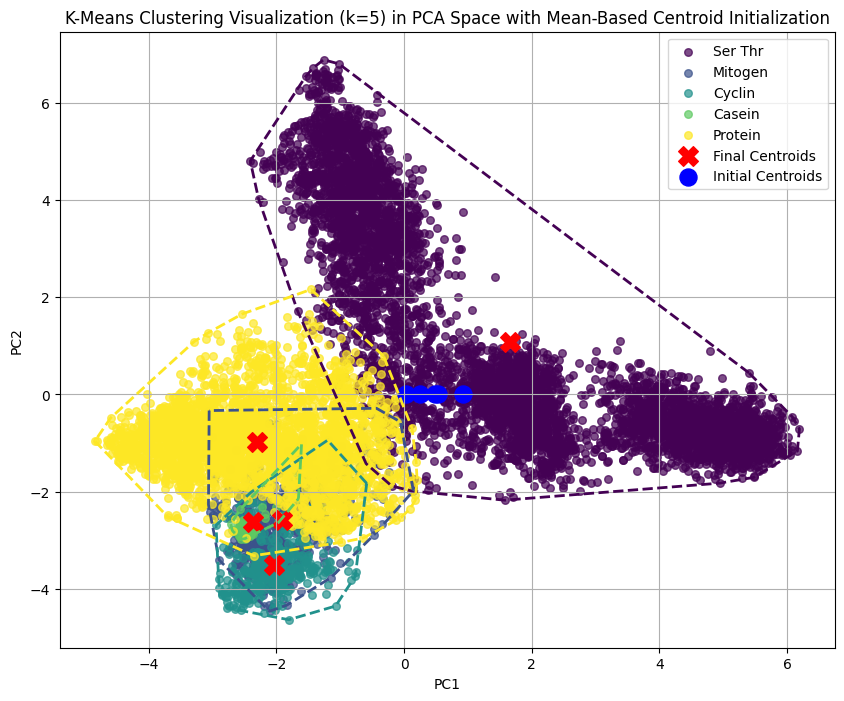

In [ ]:
k = 5
# Fit K-Means clustering
kmeans = KMeans(n_clusters=k, init=initial_centroids, n_init=1, random_state=42)
labels_kmeans = kmeans.fit_predict(flattened_matrix)
centroids = kmeans.cluster_centers_

# Créer une figure pour la visualisation
plt.figure(figsize=(10, 8))
pc1_pc2 = reduced_matrix[:, :2]
centroids_pca = pca.transform(centroids)
initial_centroids_pca = pca.transform(initial_centroids)
# Plot each cluster with a unique color and draw its convex hull
colors = plt.cm.viridis(np.linspace(0, 1, k))
for cluster in range(k):
    # Get points in the current cluster
    cluster_points = pc1_pc2[labels_kmeans == cluster]

    # Plot the points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                s=30, color=colors[cluster], alpha=0.7,
                label=f"{cluster_names[cluster]}")

    # Draw convex hull if there are enough points
    if cluster_points.shape[0] >= 3:
        hull = ConvexHull(cluster_points)
        # Get the convex hull vertices and create a closed polygon
        hull_points = cluster_points[hull.vertices]
        hull_points = np.concatenate((hull_points, hull_points[:1]), axis=0)
        plt.plot(hull_points[:, 0], hull_points[:, 1],
                 color=colors[cluster], lw=2, linestyle='--')

# Plot centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200,
            color='red', label='Final Centroids')
plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1],
            marker='o', s=150, color='blue', label='Initial Centroids')

# Customize plot
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clustering Visualization (k={k}) in PCA Space with Mean-Based Centroid Initialization")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def interactive_3d_clustering_init(flattened_matrix, k=10):
    # Reduce to 3D PCA
    pca = PCA(n_components=3)
    reduced_3d = pca.fit_transform(flattened_matrix)

    # Fit K-Means
    kmeans = KMeans(n_clusters=k, init=initial_centroids, n_init=1, random_state=42)
    labels = kmeans.fit_predict(flattened_matrix)

    # Create DataFrame with components and labels
    df = pd.DataFrame(reduced_3d, columns=['PC1', 'PC2', 'PC3'])
    df['Cluster'] = [f'Cluster {l+1}' for l in labels]
    df['Size'] = 40  # Base size for all points

    # Add centroids in PCA space
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids_pca,
                              columns=['PC1', 'PC2', 'PC3'])
    centroid_df['Cluster'] = [f'Centroid {i+1}' for i in range(k)]
    centroid_df['Size'] = 300  # Larger size for centroids

    # Combine points and centroids
    combined_df = pd.concat([df, centroid_df])

    # Create interactive 3D plot
    fig = px.scatter_3d(
        combined_df,
        x='PC1',
        y='PC2',
        z='PC3',
        color='Cluster',
        size='Size',
        size_max=25,
        opacity=0.8,
        hover_data={
            'PC1': ':.3f',
            'PC2': ':.3f',
            'PC3': ':.3f',
            'Cluster': True,
            'Size': False
        },
        title=f'3D Interactive Clustering (k={k})',
        color_discrete_sequence=px.colors.qualitative.Plotly,
        category_orders={"Cluster": [f'Cluster {i+1}' for i in range(k)] +
                         [f'Centroid {i+1}' for i in range(k)]}
    )

    # Add variance explained to axis labels
    explained_var = pca.explained_variance_ratio_ * 100
    fig.update_layout(
         width=1400,  # Wider figure
        height=900,   # Taller figure
        scene=dict(
            xaxis_title=f'PC1 ({explained_var[0]:.1f}% Variance)',
            yaxis_title=f'PC2 ({explained_var[1]:.1f}% Variance)',
            zaxis_title=f'PC3 ({explained_var[2]:.1f}% Variance)',
            camera=dict(
                eye=dict(x=2.0, y=2.0, z=0.1)  # Initial view angle
            )
        ),
        legend=dict(
            title='Clusters',
            itemsizing='constant'
        )
    )

    # Customize marker appearance
    fig.update_traces(
        marker=dict(
            line=dict(width=0.5, color='DarkSlateGrey'),
            symbol='circle'
        ),
        selector=dict(mode='markers')
    )

    return fig

fig = interactive_3d_clustering_init(flattened_matrix, k=5)
fig.show()

In [ ]:
def interactive_3d_clustering_init(flattened_matrix, initial_centroids, k=10):
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    import pandas as pd
    import plotly.express as px

    # Reduce to 3D PCA
    pca = PCA(n_components=3)
    reduced_3d = pca.fit_transform(flattened_matrix)

    # Fit K-Means
    kmeans = KMeans(n_clusters=k, init=initial_centroids, n_init=1, random_state=42)
    labels = kmeans.fit_predict(flattened_matrix)

    # Project centroids into PCA space
    final_centroids_pca = pca.transform(kmeans.cluster_centers_)
    initial_centroids_pca = pca.transform(initial_centroids)

    # Create DataFrame with components and labels
    df = pd.DataFrame(reduced_3d, columns=['PC1', 'PC2', 'PC3'])
    df['Cluster'] = [f'Cluster {l+1}' for l in labels]
    df['Size'] = 40  # Base size for data points

    # Final centroids
    final_df = pd.DataFrame(final_centroids_pca, columns=['PC1', 'PC2', 'PC3'])
    final_df['Cluster'] = [f'Final Centroid {i+1}' for i in range(k)]
    final_df['Size'] = 300

    # Initial centroids
    init_df = pd.DataFrame(initial_centroids_pca, columns=['PC1', 'PC2', 'PC3'])
    init_df['Cluster'] = [f'Initial Centroid {i+1}' for i in range(k)]
    init_df['Size'] = 250

    # Combine everything
    combined_df = pd.concat([df, final_df, init_df], ignore_index=True)

    # Define order for legend
    cluster_order = (
        [f'Cluster {i+1}' for i in range(k)] +
        [f'Final Centroid {i+1}' for i in range(k)] +
        [f'Initial Centroid {i+1}' for i in range(k)]
    )

    # Create interactive 3D plot
    fig = px.scatter_3d(
        combined_df,
        x='PC1', y='PC2', z='PC3',
        color='Cluster',
        size='Size',
        size_max=25,
        opacity=0.8,
        hover_data={
            'PC1': ':.3f',
            'PC2': ':.3f',
            'PC3': ':.3f',
            'Cluster': True,
            'Size': False
        },
        title=f'3D Interactive Clustering (k={k}) with Initial & Final Centroids',
        color_discrete_sequence=px.colors.qualitative.Set3,
        category_orders={'Cluster': cluster_order}
    )

    # Update layout with explained variance
    explained_var = pca.explained_variance_ratio_ * 100
    fig.update_layout(
        width=1400, height=900,
        scene=dict(
            xaxis_title=f'PC1 ({explained_var[0]:.1f}% Variance)',
            yaxis_title=f'PC2 ({explained_var[1]:.1f}% Variance)',
            zaxis_title=f'PC3 ({explained_var[2]:.1f}% Variance)',
            camera=dict(eye=dict(x=2.0, y=2.0, z=0.1))
        ),
        legend=dict(title='Clusters', itemsizing='constant')
    )

    return fig

fig = interactive_3d_clustering_init(flattened_matrix,initial_centroids, k=5)
fig.show()

Clusters that are similar in both kmeans : dark blue cluster, yellow/green cluster.

## PCA projections with labeled data

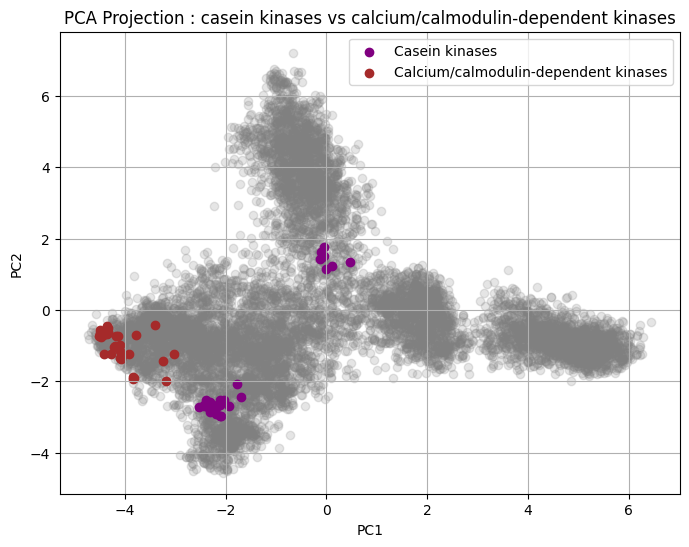

In [ ]:
pca = PCA(n_components=5)
reduced_matrix = pca.fit_transform(flattened_matrix)
reduced_casein_matrix = pca.transform(casein_flattened_matrix)
reduced_calcium_calmodulin_matrix = pca.transform(calcium_calmodulin_flattened_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], color='grey', alpha=0.2)

plt.scatter(reduced_casein_matrix[:, 0], reduced_casein_matrix[:, 1], color='purple', label="Casein kinases")
plt.scatter(reduced_calcium_calmodulin_matrix[:, 0], reduced_calcium_calmodulin_matrix[:, 1], color='brown', label="Calcium/calmodulin-dependent kinases")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection : casein kinases vs calcium/calmodulin-dependent kinases")
plt.legend()
plt.grid()
plt.show()

In [ ]:
output_dir = "PCA_projections_with_labels"
os.makedirs(output_dir, exist_ok=True)

matrices = {
    "ser_thr": ser_thr_flattened_matrix,
    "mitogen": mitogen_flattened_matrix,
    "cyclin": cyclin_flattened_matrix,
    "casein": casein_flattened_matrix,
    "protein": protein_flattened_matrix,
    "calcium": calcium_flattened_matrix,
    "calcium_calmodulin": calcium_calmodulin_flattened_matrix,
    "ribosomal": ribosomal_flattened_matrix,
    "aurora": aurora_flattened_matrix,
    "CBL": CBL_flattened_matrix,
    "cAMP_dependent": cAMP_dependent_flattened_matrix,
    "L_type_lectin": L_type_lectin_flattened_matrix,
    "tyrosine": tyrosine_flattened_matrix,
    "dual_specificity": dual_specificity_flattened_matrix,
    "eukaryotic": eukaryotic_flattened_matrix
}

pca = PCA(n_components=10)
reduced_matrix = pca.fit_transform(flattened_matrix)

reduced_matrices = {name: pca.transform(mat) for name, mat in matrices.items()}

for (name1, mat1), (name2, mat2) in itertools.combinations(reduced_matrices.items(), 2):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot settings
    combos = [ (0, 1), (0, 2), (1, 2) ]
    titles = [ "PC1 vs PC2", "PC1 vs PC3", "PC2 vs PC3" ]

    for ax, (i, j), title in zip(axs.flat[:3], combos, titles):
        # Scatter all points in grey
        ax.scatter(reduced_matrix[:, i], reduced_matrix[:, j], color='grey', alpha=0.1)

        # Highlight the two matrices
        ax.scatter(mat1[:, i], mat1[:, j], label=name1, alpha=0.7)
        ax.scatter(mat2[:, i], mat2[:, j], label=name2, alpha=0.7)

        ax.set_xlabel(f"PC{i+1}")
        ax.set_ylabel(f"PC{j+1}")
        ax.set_title(title)
        ax.grid(True)

    # Turn off the fourth subplot
    axs[1, 1].axis("off")

    # Create the legend manually using handles from one of the subplots
    handles1, labels1 = axs[0, 0].get_legend_handles_labels()
    axs[1, 1].legend(handles1, labels1, loc="center", fontsize=12, frameon=False)

    plt.suptitle(f"PCA Projections: {name1} vs {name2}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.savefig(os.path.join(output_dir, f"pca_{name1}_vs_{name2}.png"))
    plt.close()

In [ ]:
import shutil

shutil.make_archive('PCA_projections_with_labels', 'zip', '/content/PCA_projections_with_labels')

from google.colab import files

files.download('PCA_projections_with_labels.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from Bio import pairwise2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def sequence_identity(seq1, seq2):
    min_len = min(len(seq1), len(seq2))
    matches = sum(a == b for a, b in zip(seq1, seq2))
    return matches / max(len(seq1), len(seq2))

def compute_identity_matrix(sequences):
    n = len(sequences)
    identity_matrix = np.eye(n)
    for i in tqdm(range(n), desc="Computing identity matrix"):
        for j in range(i+1, n):
            id_score = sequence_identity(sequences[i], sequences[j])
            identity_matrix[i, j] = identity_matrix[j, i] = id_score
    return identity_matrix

def cluster_sequences(sequences, N=200, threshold=0.3):
    n = len(sequences)
    identity_matrix = compute_identity_matrix(sequences)
    assigned = np.zeros(n, dtype=bool)
    clusters = []

    while not np.all(assigned):
        idx = np.where(~assigned)[0][0]
        cluster = [idx]
        assigned[idx] = True

        similarities = identity_matrix[idx]
        valid_indices = np.where((similarities >= threshold) & (~assigned))[0]
        if len(valid_indices) > 0:
            top_indices = valid_indices[np.argsort(similarities[valid_indices])[-N:]]
            cluster.extend(top_indices)
            assigned[top_indices] = True

        clusters.append(cluster)

    return clusters

def evaluate_thresholds(sequences, N=200, thresholds=np.linspace(0.0, 1.0, 11), batch_limit=None):
    if batch_limit:
        sequences = sequences[:batch_limit]
        print(f"Working on a batch of {batch_limit} sequences.")

    results = []
    for t in thresholds:
        print(f"Threshold: {t:.2f}")
        clusters = cluster_sequences(sequences, N=N, threshold=t)
        print(f"Clusters formed: {len(clusters)}\n")
        results.append(len(clusters))
    return thresholds, results

def plot_clusters_vs_threshold(thresholds, cluster_counts):
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, cluster_counts, marker='o')
    plt.xlabel("Sequence Identity Threshold")
    plt.ylabel("Number of Clusters")
    plt.title("Number of Clusters vs Sequence Identity Threshold")
    plt.grid(True)
    plt.show()

# Exécution sur batch test pour éviter le coût complet
# thresholds, cluster_counts = evaluate_thresholds(small_batch_seq_list, N=1000)
# plot_clusters_vs_threshold(thresholds, cluster_counts)

/usr/local/lib/python3.11/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [ ]:
import pandas as pd

# Données des seuils et du nombre de clusters
data = {
    "Threshold": [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00],
    "Clusters formed": [10, 11, 32, 450, 1657, 3084, 4412, 5922, 7409, 8893, 10000]
}

# Création du DataFrame
df = pd.DataFrame(data)

# Affichage du tableau sous forme de code LaTeX pour un article
latex_table = df.to_latex(index=False, caption="Tableau des clusters formés en fonction du seuil d'identité de séquence", label="tab:clusters")

# Affichage du tableau
print(latex_table)


\begin{table}
\caption{Tableau des clusters formés en fonction du seuil d'identité de séquence}
\label{tab:clusters}
\begin{tabular}{rr}
\toprule
Threshold & Clusters formed \\
\midrule
0.000000 & 10 \\
0.100000 & 11 \\
0.200000 & 32 \\
0.300000 & 450 \\
0.400000 & 1657 \\
0.500000 & 3084 \\
0.600000 & 4412 \\
0.700000 & 5922 \\
0.800000 & 7409 \\
0.900000 & 8893 \\
1.000000 & 10000 \\
\bottomrule
\end{tabular}
\end{table}



Threshold: 0.00


Computing identity matrix: 100%|██████████| 3226/3226 [03:34<00:00, 15.05it/s] 


Clusters formed: 17

Threshold: 0.10


Computing identity matrix: 100%|██████████| 3226/3226 [03:30<00:00, 15.36it/s] 


Clusters formed: 1332

Threshold: 0.20


Computing identity matrix: 100%|██████████| 3226/3226 [03:31<00:00, 15.27it/s] 


Clusters formed: 1962

Threshold: 0.30


Computing identity matrix: 100%|██████████| 3226/3226 [03:32<00:00, 15.15it/s] 


Clusters formed: 2097

Threshold: 0.40


Computing identity matrix: 100%|██████████| 3226/3226 [03:29<00:00, 15.39it/s] 


Clusters formed: 2202

Threshold: 0.50


Computing identity matrix: 100%|██████████| 3226/3226 [03:30<00:00, 15.32it/s] 


Clusters formed: 2287

Threshold: 0.60


Computing identity matrix: 100%|██████████| 3226/3226 [03:29<00:00, 15.42it/s] 


Clusters formed: 2364

Threshold: 0.70


Computing identity matrix: 100%|██████████| 3226/3226 [03:30<00:00, 15.34it/s] 


Clusters formed: 2432

Threshold: 0.80


Computing identity matrix: 100%|██████████| 3226/3226 [03:28<00:00, 15.47it/s] 


Clusters formed: 2521

Threshold: 0.90


Computing identity matrix: 100%|██████████| 3226/3226 [03:30<00:00, 15.35it/s] 


Clusters formed: 2634

Threshold: 1.00


Computing identity matrix: 100%|██████████| 3226/3226 [03:28<00:00, 15.46it/s] 


Clusters formed: 3149



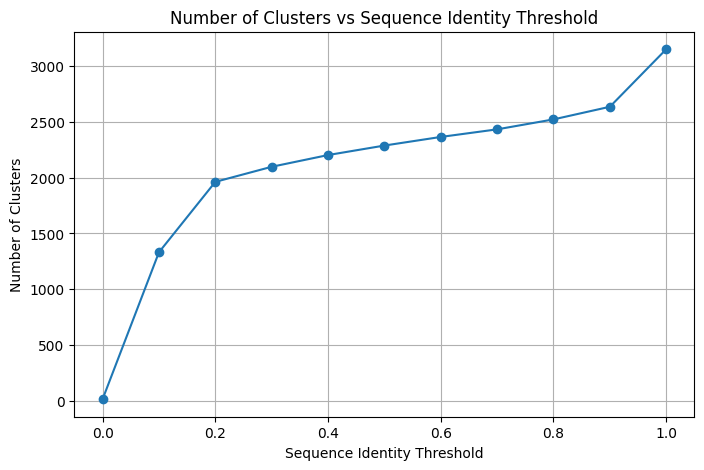

In [ ]:
thresholds, cluster_counts = evaluate_thresholds(sequence_list)
plot_clusters_vs_threshold(thresholds, cluster_counts)

# Classification task

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_map = retrieve_labels(sequence_codes, protein_names)
print("Number of labels :", len(label_map))
code_to_label = {code: label for label, codes in label_map.items() for code in codes}
print("Number of total labeled data :", len(code_to_label))

X_train = [seq for code, seq in zip(all_sequence_codes, all_sequences) if code in code_to_label]
X_train = np.vstack(X_train)

Y_train = [code_to_label[code] for code in all_sequence_codes if code in code_to_label]
print("Number of labeled data for the 15 most represented labels :", len(Y_train))
print(Y_train)
encoder = LabelEncoder()
Y_train_encoded = encoder.fit_transform(Y_train)

assert(X_train.shape[0] == len(Y_train))

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, Y_train)

Number of labels : 235
Number of total labeled data : 3058
Number of labeled data for the 15 most represented labels : 1757
['Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Putative serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Probable serine/threonine-protein', 'Serine/threonine-protein', 'CBL-interacting serine/threonine-protein', 'Serine/threonine-protein', 'Probable serine/threonine-protein', 'Serine/threonine-protein', 'Serine/threonine-protein', 'Probable serine/threonine-protein', 'Serine/thr

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
X_test_seq_list, X_test_seq_codes = select_random_sequences(full_data_seq_list, full_data_seq_codes, num_samples=10000)
X_test, removed_indices = encode_sequences_one_hot_with_gap(X_test_seq_list, max_length=None, return_removed_indices=True)
M, L, A = X_test.shape
X_test = X_test.reshape(M, L*A)
print("Number of test data :", X_test.shape[0])
X_test_seq_codes = [code for idx, code in enumerate(X_test_seq_codes) if idx not in removed_indices]

Y_pred = model.predict(X_test)
np.set_printoptions(threshold=np.inf)
print(Y_pred)

Number of test data : 9961
['Serine/threonine-protein' 'Calcium-dependent protein'
 'Serine/threonine-protein' 'Probable serine/threonine-protein'
 'Serine/threonine-protein' 'Serine/threonine-protein'
 'Serine/threonine-protein' 'Probable serine/threonine-protein'
 'Serine/threonine-protein' 'Serine/threonine-protein'
 'Serine/threonine-protein' 'Serine/threonine-protein' 'Cyclin-dependent'
 'Protein' 'Serine/threonine-protein' 'Probable serine/threonine-protein'
 'Serine/threonine-protein' 'Serine/threonine-protein'
 'L-type lectin-domain containing receptor' 'Ribosomal protein S6'
 'Serine/threonine-protein' 'Mitogen-activated protein'
 'Probable serine/threonine-protein' 'Serine/threonine-protein'
 'Serine/threonine-protein' 'L-type lectin-domain containing receptor'
 'Serine/threonine-protein' 'Serine/threonine-protein'
 'Serine/threonine-protein' 'Serine/threonine-protein'
 'Calcium-dependent protein' 'Serine/threonine-protein'
 'Probable serine/threonine-protein' 'Serine/threoni

In [ ]:
def retrieve_protein_uniprot_labels(codes):
    uniprot_labels = {}
    for code in codes:
        info = get_protein_info(code)
        annotation_score = info['annotationScore']
        if info['entryType'] == 'Inactive':
            protein_name = 'Inactive'
        else :
            protein_description = info['proteinDescription']
            if 'submissionNames' in protein_description.keys():
                protein_name = protein_description['submissionNames'][0]['fullName']['value']
            else :
                protein_name = protein_description['recommendedName']['fullName']['value']
        uniprot_labels[code] = (protein_name, annotation_score)
    return uniprot_labels

uniprot_labels = retrieve_protein_uniprot_labels(X_test_seq_codes)
print(len(uniprot_labels))
np.set_printoptions(threshold=np.inf)
print(uniprot_labels)

9961
{'A0A8S1NVY1': ('Protein kinase domain-containing protein', 2.0), 'A0A8S1QPG6': ('Calcium-dependent protein kinase', 1.0), 'A0A8T0T2Z3': ('Protein kinase domain-containing protein', 2.0), 'A0A453DPT0': ('Protein kinase domain-containing protein', 2.0), 'A0A7V8IWU4': ('Protein kinase domain-containing protein', 1.0), 'E5A6K2': ('Protein kinase domain-containing protein', 1.0), 'A0A8H7AME2': ('Protein kinase domain-containing protein', 2.0), 'A0A4Y7I6C2': ('Protein kinase domain-containing protein', 2.0), 'K7G9J6': ('Tyrosine-protein kinase receptor', 5.0), 'A0A6P7FAY8': ('non-specific serine/threonine protein kinase', 2.0), 'A0A3A6N3B7': ('non-specific serine/threonine protein kinase', 4.0), 'A0AAV8R4K4': ('Protein kinase domain-containing protein', 2.0), 'A0A8C3RYP0': ('Cyclin dependent kinase like 3', 2.0), 'A0A3S2PG73': ('Protein kinase C', 2.0), 'A0AAU1XA80': ('non-specific serine/threonine protein kinase', 2.0), 'A0AA88AVB0': ('Protein kinase domain-containing protein', 1.0), 

In [ ]:
labels_only = [label for label, _ in uniprot_labels.values()]

labels = []
for label in labels_only:
        m = re.search(r"([\w\s/-]+) kinase", label, re.IGNORECASE)
        if m:
            labels.append(m.group(1))
        else:
            labels.append('')

print(len(labels))
print(labels)

9961
['Protein', 'Calcium-dependent protein', 'Protein', 'Protein', 'Protein', 'Protein', 'Protein', 'Protein', 'Tyrosine-protein', 'non-specific serine/threonine protein', 'non-specific serine/threonine protein', 'Protein', 'Cyclin dependent', 'Protein', 'non-specific serine/threonine protein', 'Protein', 'CAMK/CAMKL/GIN4 protein', 'Serine/threonine protein', 'Protein', 'non-specific serine/threonine protein', 'non-specific serine/threonine protein', 'Protein', 'Protein', 'Protein', 'Protein', 'Receptor-like serine/threonine-protein', '', 'AGC/AKT protein', '', 'Serine/threonine-protein', 'Calcium-dependent protein', 'mitogen-activated protein kinase', 'Protein', 'Protein', 'non-specific serine/threonine protein', 'non-specific serine/threonine protein', 'G protein-coupled receptor', '', 'Serine/threonine protein', 'Tyrosine-protein', '', 'Serine/threonine-protein', 'Protein', 'Protein', 'protein', 'Protein', 'non-specific serine/threonine protein', 'Serine/threonine-protein', '', 'Se

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(labels, Y_pred)
print("Accuracy:", accuracy)

# Rapport complet (précision, rappel, F1-score par classe)
# print("Classification Report:")
# print(classification_report(labels, Y_pred))

# Matrice de confusion
# print("Confusion Matrix:")
# print(confusion_matrix(labels, Y_pred))

Accuracy: 0.09617508282300974


In [ ]:
ser_thr_labels = {
    "Serine/threonine-protein",
    "Probable serine/threonine-protein",
    "CBL-interacting serine/threonine-protein",
    "Putative serine/threonine-protein",
    "LRR receptor-like serine/threonine-protein",
    "G-type lectin S-receptor-like serine/threonine-protein",
    "Probable LRR receptor-like serine/threonine-protein",
    "MAP kinase-interacting serine/threonine-protein",
    "Testis-specific serine/threonine-protein",
    "Microtubule-associated serine/threonine-protein",
    "Probable inactive serine/threonine-protein",
    "Serine/threonine protein",
    "RAF proto-oncogene serine/threonine-protein",
    "Leucine-rich repeat receptor-like serine/threonine-protein",
    "Receptor-interacting serine/threonine-protein",
    "Serine/threonine",
    "Proto-oncogene serine/threonine-protein",
    "RAC-alpha serine/threonine-protein",
    "RAC-beta serine/threonine-protein",
    "Leucine-rich repeat serine/threonine-protein",
    "Probable serine/threonine protein",
    "Mitotic checkpoint serine/threonine-protein",
    "STE20-like serine/threonine-protein",
    "Receptor-like serine/threonine-protein",
    "Inactive serine/threonine-protein"
}
ser_thr_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in ser_thr_labels]]
ser_thr_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in ser_thr_labels]]


mitogen_labels = {
    "Mitogen-activated protein",
    "Mitogen-activated protein kinase",
    "Mitogen-activated protein kinase kinase",
    "Dual specificity mitogen-activated protein kinase",
    "Mitogen-activated protein kinase kinase kinase",
    "Mitogen-activated protein kinase kinae",
    "Sporulation-specific mitogen-activated protein",
    "Putative mitogen-activated protein",
    "Putative mitogen-activated protein kinase"
}
mitogen_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in mitogen_labels]]
mitogen_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in mitogen_labels]]


cyclin_labels = {
    "Cyclin-dependent",
    "Probable cyclin-dependent",
    "Cyclin-G-associated",
    "Cyclin-dependent-like",
    "Probable cyclin-dependent serine/threonine-protein",
    "Cyclin-dependent protein",
    "Putative cyclin-dependent",
    "Putative cyclin-dependent serine/threonine-protein"
}
cyclin_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in cyclin_labels]]
cyclin_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in cyclin_labels]]


casein_labels = {
    "Casein",
    "Probable casein",
    "Putative casein",
    "Inactive casein"
}
casein_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in casein_labels]]
casein_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in casein_labels]]


protein_labels = {
    "Protein"
}
protein_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in protein_labels]]
protein_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in protein_labels]]


calcium_labels = {
    "Calcium-dependent protein"
}
calcium_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in calcium_labels]]
calcium_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in calcium_labels]]


calcium_calmodulin_labels = {
    "Calcium/calmodulin-dependent protein",
    "Calcium/calmodulin-dependent protein kinase",
    "Calcium/calmodulin-dependent serine/threonine-protein",
    "Calcium/calmodulin-regulated receptor-like"
}
calcium_calmodulin_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in calcium_calmodulin_labels]]
calcium_calmodulin_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in calcium_calmodulin_labels]]


ribosomal_labels = {
    "Ribosomal protein S6",
    "Putative ribosomal protein S6"
}
ribosomal_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in ribosomal_labels]]
ribosomal_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in ribosomal_labels]]


aurora_labels = {
    "Aurora",
    "Aurora/IPL1-related protein"
}
aurora_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in aurora_labels]]
aurora_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in aurora_labels]]


CBL_labels = {
    "CBL-interacting protein",
    "CBL-interacting serine/threonine-protein",
    "Putative CBL-interacting protein"
}
CBL_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in CBL_labels]]
CBL_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in CBL_labels]]


cAMP_dependent_labels = {
    "cAMP-dependent protein",
    "Probable cAMP-dependent protein"
}
cAMP_dependent_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in cAMP_dependent_labels]]
cAMP_dependent_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in cAMP_dependent_labels]]


L_type_lectin_labels = {
    "L-type lectin-domain containing receptor",
    "Probable L-type lectin-domain containing receptor",
    "Putative L-type lectin-domain containing receptor"
}
L_type_lectin_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in L_type_lectin_labels]]
L_type_lectin_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in L_type_lectin_labels]]


tyrosine_labels = {
    "Dual specificity tyrosine-phosphorylation-regulated",
    "Membrane-associated tyrosine- and threonine-specific cdc2-inhibitory",
    "Inactive tyrosine-protein",
    "Receptor protein-tyrosine"
}
tyrosine_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in tyrosine_labels]]
tyrosine_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in tyrosine_labels]]


dual_specificity_labels = {
    "Dual specificity protein",
    "Probable dual specificity protein"
}
dual_specificity_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in dual_specificity_labels]]
dual_specificity_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in dual_specificity_labels]]


eukaryotic_labels = {
    "Eukaryotic translation initiation factor 2-alpha"
}
eukaryotic_pred_matrix = X_test[[i for i, label in enumerate(Y_pred) if label in eukaryotic_labels]]
eukaryotic_uniprot_matrix = X_test[[i for i, label in enumerate(labels) if label in eukaryotic_labels]]

In [ ]:
ser_thr_pred_indexes = [i for i, label in enumerate(Y_pred) if label in ser_thr_labels]
ser_thr_uniprot_indexes = [i for i, label in enumerate(labels) if label in ser_thr_labels]

mitogen_pred_indexes = [i for i, label in enumerate(Y_pred) if label in mitogen_labels]
mitogen_uniprot_indexes = [i for i, label in enumerate(labels) if label in mitogen_labels]

cyclin_pred_indexes = [i for i, label in enumerate(Y_pred) if label in cyclin_labels]
cyclin_uniprot_indexes = [i for i, label in enumerate(labels) if label in cyclin_labels]

casein_pred_indexes = [i for i, label in enumerate(Y_pred) if label in casein_labels]
casein_uniprot_indexes = [i for i, label in enumerate(labels) if label in casein_labels]

protein_pred_indexes = [i for i, label in enumerate(Y_pred) if label in protein_labels]
protein_uniprot_indexes = [i for i, label in enumerate(labels) if label in protein_labels]

calcium_pred_indexes = [i for i, label in enumerate(Y_pred) if label in calcium_labels]
calcium_uniprot_indexes = [i for i, label in enumerate(labels) if label in calcium_labels]

calcium_calmodulin_pred_indexes = [i for i, label in enumerate(Y_pred) if label in calcium_calmodulin_labels]
calcium_calmodulin_uniprot_indexes = [i for i, label in enumerate(labels) if label in calcium_calmodulin_labels]

ribosomal_pred_indexes = [i for i, label in enumerate(Y_pred) if label in ribosomal_labels]
ribosomal_uniprot_indexes = [i for i, label in enumerate(labels) if label in ribosomal_labels]

aurora_pred_indexes = [i for i, label in enumerate(Y_pred) if label in aurora_labels]
aurora_uniprot_indexes = [i for i, label in enumerate(labels) if label in aurora_labels]

CBL_pred_indexes = [i for i, label in enumerate(Y_pred) if label in CBL_labels]
CBL_uniprot_indexes = [i for i, label in enumerate(labels) if label in CBL_labels]

cAMP_dependent_pred_indexes = [i for i, label in enumerate(Y_pred) if label in cAMP_dependent_labels]
cAMP_dependent_uniprot_indexes = [i for i, label in enumerate(labels) if label in cAMP_dependent_labels]

L_type_lectin_pred_indexes = [i for i, label in enumerate(Y_pred) if label in L_type_lectin_labels]
L_type_lectin_uniprot_indexes = [i for i, label in enumerate(labels) if label in L_type_lectin_labels]

tyrosine_pred_indexes = [i for i, label in enumerate(Y_pred) if label in tyrosine_labels]
tyrosine_uniprot_indexes = [i for i, label in enumerate(labels) if label in tyrosine_labels]

dual_specificity_pred_indexes = [i for i, label in enumerate(Y_pred) if label in dual_specificity_labels]
dual_specificity_uniprot_indexes = [i for i, label in enumerate(labels) if label in dual_specificity_labels]

eukaryotic_pred_indexes = [i for i, label in enumerate(Y_pred) if label in eukaryotic_labels]
eukaryotic_uniprot_indexes = [i for i, label in enumerate(labels) if label in eukaryotic_labels]

def calculate_identity_percentage(pred_indexes, uniprot_indexes):
    # Calcul de l'intersection des deux listes
    intersection = set(pred_indexes) & set(uniprot_indexes)

    # Calcul du pourcentage d'identité
    identity_percentage = (len(intersection) / len(pred_indexes)) * 100 if len(pred_indexes) > 0 else 0
    return identity_percentage

# Calcul des pourcentages d'identité pour chaque paire
eukaryotic_identity = calculate_identity_percentage(eukaryotic_pred_indexes, eukaryotic_uniprot_indexes)
aurora_identity = calculate_identity_percentage(aurora_pred_indexes, aurora_uniprot_indexes)
CBL_identity = calculate_identity_percentage(CBL_pred_indexes, CBL_uniprot_indexes)
cAMP_dependent_identity = calculate_identity_percentage(cAMP_dependent_pred_indexes, cAMP_dependent_uniprot_indexes)
L_type_lectin_identity = calculate_identity_percentage(L_type_lectin_pred_indexes, L_type_lectin_uniprot_indexes)
tyrosine_identity = calculate_identity_percentage(tyrosine_pred_indexes, tyrosine_uniprot_indexes)
dual_specificity_identity = calculate_identity_percentage(dual_specificity_pred_indexes, dual_specificity_uniprot_indexes)
mitogen_identity = calculate_identity_percentage(mitogen_pred_indexes, mitogen_uniprot_indexes)
cyclin_identity = calculate_identity_percentage(cyclin_pred_indexes, cyclin_uniprot_indexes)
casein_identity = calculate_identity_percentage(casein_pred_indexes, casein_uniprot_indexes)
protein_identity = calculate_identity_percentage(protein_pred_indexes, protein_uniprot_indexes)
calcium_identity = calculate_identity_percentage(calcium_pred_indexes, calcium_uniprot_indexes)
calcium_calmodulin_identity = calculate_identity_percentage(calcium_calmodulin_pred_indexes, calcium_calmodulin_uniprot_indexes)
ribosomal_identity = calculate_identity_percentage(ribosomal_pred_indexes, ribosomal_uniprot_indexes)
ser_thr_identity = calculate_identity_percentage(ser_thr_pred_indexes, ser_thr_uniprot_indexes)

# Affichage des résultats
print(f"Ser/Thr identity: {ser_thr_identity:.2f}%")
print(f"Mitogen identity: {mitogen_identity:.2f}%")
print(f"Cyclin identity: {cyclin_identity:.2f}%")
print(f"Casein identity: {casein_identity:.2f}%")
print(f"Protein identity: {protein_identity:.2f}%")
print(f"Calcium identity: {calcium_identity:.2f}%")
print(f"Calcium-calmodulin identity: {calcium_calmodulin_identity:.2f}%")
print(f"Ribosomal identity: {ribosomal_identity:.2f}%")
print(f"Aurora identity: {aurora_identity:.2f}%")
print(f"CBL identity: {CBL_identity:.2f}%")
print(f"cAMP-dependent identity: {cAMP_dependent_identity:.2f}%")
print(f"L-type lectin identity: {L_type_lectin_identity:.2f}%")
print(f"Tyrosine identity: {tyrosine_identity:.2f}%")
print(f"Dual specificity identity: {dual_specificity_identity:.2f}%")
print(f"Eukaryotic identity: {eukaryotic_identity:.2f}%")


Ser/Thr identity: 13.84%
Mitogen identity: 32.29%
Cyclin identity: 35.33%
Casein identity: 46.97%
Protein identity: 37.67%
Calcium identity: 45.45%
Calcium-calmodulin identity: 29.87%
Ribosomal identity: 53.52%
Aurora identity: 68.42%
CBL identity: 0.00%
cAMP-dependent identity: 50.00%
L-type lectin identity: 6.90%
Tyrosine identity: 0.00%
Dual specificity identity: 9.68%
Eukaryotic identity: 0.00%


In [ ]:
import pandas as pd
from tabulate import tabulate

# Créer un dictionnaire avec les données
data = {
    'Category': [
        'Ser/Thr identity', 'Mitogen identity', 'Cyclin identity', 'Casein identity',
        'Protein identity', 'Calcium identity', 'Calcium-calmodulin identity',
        'Ribosomal identity', 'Aurora identity', 'CBL identity',
        'cAMP-dependent identity', 'L-type lectin identity',
        'Tyrosine identity', 'Dual specificity identity', 'Eukaryotic identity'
    ],
    'Identity (%)': [
        13.84, 32.29, 35.33, 46.97, 37.67, 45.45, 29.87,
        53.52, 68.42, 0.00, 50.00, 6.90, 0.00, 9.68, 0.00
    ]
}

# Créer un DataFrame à partir des données
df = pd.DataFrame(data)

# Générer le tableau sous forme de texte avec Tabulate
table = tabulate(df, headers='keys', tablefmt='pretty', showindex=False)

# Afficher le tableau
print(table)


+-----------------------------+--------------+
|          Category           | Identity (%) |
+-----------------------------+--------------+
|      Ser/Thr identity       |    13.84     |
|      Mitogen identity       |    32.29     |
|       Cyclin identity       |    35.33     |
|       Casein identity       |    46.97     |
|      Protein identity       |    37.67     |
|      Calcium identity       |    45.45     |
| Calcium-calmodulin identity |    29.87     |
|     Ribosomal identity      |    53.52     |
|       Aurora identity       |    68.42     |
|        CBL identity         |     0.0      |
|   cAMP-dependent identity   |     50.0     |
|   L-type lectin identity    |     6.9      |
|      Tyrosine identity      |     0.0      |
|  Dual specificity identity  |     9.68     |
|     Eukaryotic identity     |     0.0      |
+-----------------------------+--------------+


In [ ]:
labels_indices = {
    "ser_thr": (ser_thr_pred_matrix, ser_thr_uniprot_matrix),
    "mitogen": (mitogen_pred_matrix, mitogen_uniprot_matrix),
    "cyclin": (cyclin_pred_matrix, cyclin_uniprot_matrix),
    "casein": (casein_pred_matrix, casein_uniprot_matrix),
    "protein": (protein_pred_matrix, protein_uniprot_matrix),
    "calcium": (calcium_pred_matrix, calcium_uniprot_matrix),
    "calcium_calmodulin": (calcium_calmodulin_pred_matrix, calcium_calmodulin_uniprot_matrix),
    "ribosomal": (ribosomal_pred_matrix, ribosomal_uniprot_matrix),
    "aurora": (aurora_pred_matrix, aurora_uniprot_matrix),
    "CBL": (CBL_pred_matrix, CBL_uniprot_matrix),
    "cAMP_dependent": (cAMP_dependent_pred_matrix, cAMP_dependent_uniprot_matrix),
    "L_type_lectin": (L_type_lectin_pred_matrix, L_type_lectin_uniprot_matrix),
    "tyrosine": (tyrosine_pred_matrix, tyrosine_uniprot_matrix),
    "dual_specificity": (dual_specificity_pred_matrix, dual_specificity_uniprot_matrix),
    "eukaryotic": (eukaryotic_pred_matrix, eukaryotic_uniprot_matrix),
}

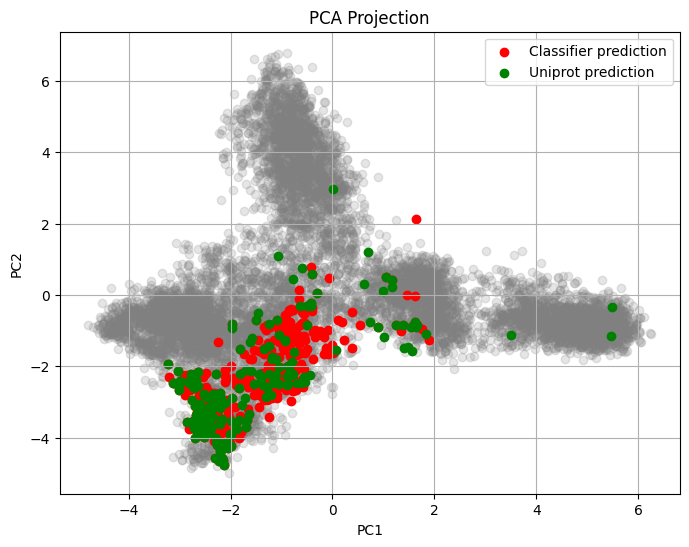

In [ ]:
assert(len(Y_pred) == len(labels))

pca = PCA(n_components=5)
reduced_matrix = pca.fit_transform(X_test)

reduced_class_pred_matrix = pca.transform(mitogen_pred_matrix)
reduced_uniprot_pred_matrix = pca.transform(mitogen_uniprot_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], color='grey', alpha=0.2)

plt.scatter(reduced_class_pred_matrix[:, 0], reduced_class_pred_matrix[:, 1], color='red', label="Classifier prediction")
plt.scatter(reduced_uniprot_pred_matrix[:, 0], reduced_uniprot_pred_matrix[:, 1], color='green', label="Uniprot prediction")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")
plt.legend()
plt.grid()
plt.show()

In [ ]:
output_dir = "PCA_projections_for_classified_sequences"
os.makedirs(output_dir, exist_ok=True)

assert(len(Y_pred) == len(labels))

pca = PCA(n_components=5)
reduced_matrix = pca.fit_transform(X_test)

for name, (pred_matrix, uniprot_matrix) in labels_indices.items():
    if pred_matrix.shape[0] == 0 or uniprot_matrix.shape[0] == 0:
        print(f"Skipping label '{name}' due to empty matrix.")
        continue

    reduced_pred = pca.transform(pred_matrix)
    reduced_uniprot = pca.transform(uniprot_matrix)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], color='grey', alpha=0.2)
    plt.scatter(reduced_pred[:, 0], reduced_pred[:, 1], color='red', label="Classifier prediction")
    plt.scatter(reduced_uniprot[:, 0], reduced_uniprot[:, 1], color='green', label="Uniprot label")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA - Label: {name}")
    plt.legend()
    plt.grid()

    plt.savefig(os.path.join(output_dir, f"pca_{name}.png"))
    plt.close()

In [ ]:
import shutil

shutil.make_archive('PCA_projections_for_classified_sequences', 'zip', '/content/PCA_projections_for_classified_sequences')

from google.colab import files

files.download('PCA_projections_for_classified_sequences.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PCA projection of artificial sequences

In [ ]:
artificial_sequences_list = read_fasta('/content/all_synthetic_sequences.fasta')
encoded_art_seq_matrix = encode_sequences_one_hot_with_gap(artificial_sequences_list, max_length=None)
print("Shape of encoded matrix :", encoded_art_seq_matrix.shape, "\n")
M, L, A = encoded_art_seq_matrix.shape
flattened_art_seq_matrix = encoded_art_seq_matrix.reshape(M, L*A)

Shape of encoded matrix : (1134, 263, 21) 



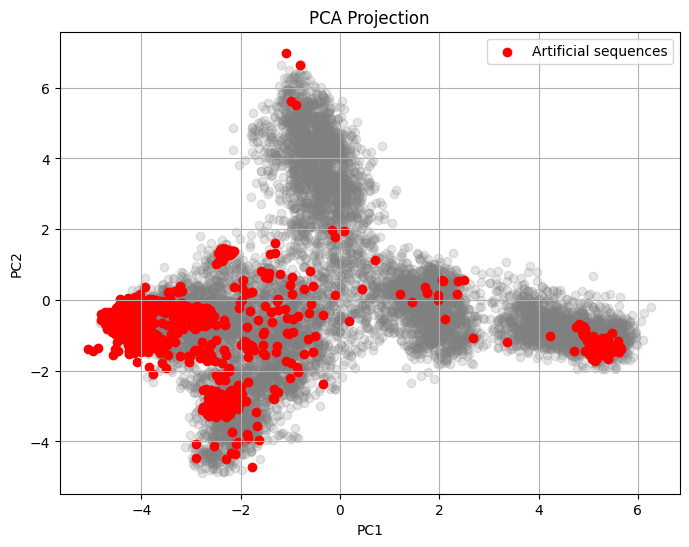

In [ ]:
pca = PCA(n_components=5)
reduced_matrix = pca.fit_transform(flattened_matrix)
reduced_art_seq_matrix = pca.transform(flattened_art_seq_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], color='grey', alpha=0.2)

plt.scatter(reduced_art_seq_matrix[:, 0], reduced_art_seq_matrix[:, 1], color='red', label="Artificial sequences")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")
plt.legend()
plt.grid()
plt.show()